In [19]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, fbeta_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

## 📌 Business Understanding

### 🎯 Latar Belakang Masalah
Perusahaan asuransi perjalanan memiliki tantangan besar dalam **mengelola risiko klaim** yang datang dari para pemegang polis. Tidak semua pemegang polis akan melakukan klaim, tetapi kegagalan dalam mengantisipasi siapa yang kemungkinan besar akan mengajukan klaim (**False Negative**) dapat menyebabkan kerugian finansial serius. 

Sebaliknya, kesalahan dalam memprediksi bahwa seseorang akan klaim padahal tidak (**False Positive**) dapat menyebabkan **pengeluaran operasional yang tidak perlu**, seperti:
- Pemberian premi tinggi,
- Mitigasi risiko yang salah sasaran,
- Hingga berkurangnya kepuasan pelanggan.

---

### 🧑‍💼 Stakeholder

**Stakeholder utama dalam proyek ini adalah:**

- **Tim Manajemen Risiko & Underwriting**  
  Mereka yang menentukan tarif premi dan evaluasi risiko berdasarkan prediksi model.

- **Manajer Produk Asuransi**  
  Merancang produk berdasarkan segmentasi risiko yang ditentukan oleh prediksi model.

- **Tim Data Science / IT**  
  Sebagai pengembang dan pengguna model untuk diintegrasikan ke sistem underwriting otomatis.

---

### ❗ Masalah yang Dihadapi

Perusahaan **belum memiliki sistem prediktif** untuk mengidentifikasi secara otomatis pelanggan yang berpotensi melakukan klaim asuransi. Saat ini proses penilaian risiko masih manual atau berdasarkan segmentasi kasar, sehingga:

- **Tidak efisien:** Potensi **False Negative (FN)** tinggi → klaim besar tidak terdeteksi.
- **Overestimasi risiko:** Jika terlalu konservatif → **False Positive (FP)** tinggi → premi terlalu mahal → kehilangan pelanggan.

---

### 🎯 Tujuan dan Target

Mengembangkan **model Machine Learning** yang mampu:

- Memprediksi dengan akurasi tinggi **siapa pelanggan yang akan mengajukan klaim**.
- Fokus pada peningkatan **recall (atau F2 Score)** pada pelanggan yang benar-benar mengajukan klaim.
- Target metrik: **Recall ≥ 85% pada kelas klaim**.

**Penggunaan model:**
- Digunakan **saat calon pelanggan mengisi formulir pembelian asuransi**.
- Membantu tim underwriting dalam menyesuaikan premi dan perlindungan secara otomatis.

---

### 📅 Kapan dan Bagaimana Model Digunakan

- **Kapan digunakan:**  
  Saat pelanggan mengisi formulir aplikasi asuransi dan sistem sudah memiliki data awal seperti:
  - Usia,
  - Durasi perjalanan,
  - Destinasi,
  - Jenis produk asuransi yang dipilih.

- **Bagaimana digunakan:**  
  Model memprediksi probabilitas klaim. Jika hasilnya tinggi, maka sistem:

  - Memberikan penawaran **premi lebih tinggi**,
  - **Menyarankan tambahan proteksi**,
  - **Menandai kasus** untuk ditinjau manual oleh tim underwriting.



# Evaluation Metrics untuk Data Travel Insurance

"""
Type 1 error : False Positive (FP)
Konsekuensi: Perusahaan mengira nasabah akan klaim, padahal tidak. Dampaknya: potensi overestimasi risiko, premi lebih tinggi, atau tindakan pencegahan yang tidak perlu.

Type 2 error : False Negative (FN)
Konsekuensi: Perusahaan gagal mendeteksi nasabah yang benar-benar akan klaim. Dampaknya: risiko finansial lebih besar karena klaim tidak terantisipasi.

Berdasarkan konsekuensinya:
- FN (False Negative) lebih merugikan bisnis asuransi perjalanan, karena klaim yang tidak terdeteksi bisa menyebabkan kerugian finansial.
- Maka, model harus memaksimalkan deteksi klaim (positif), yaitu recall pada kelas klaim.

Metrik yang sesuai:
- **Recall** pada kelas klaim (positif): mengukur seberapa banyak klaim yang berhasil dideteksi.
- **F2 Score**: menyeimbangkan recall dan precision, namun lebih menekankan recall.
- **ROC AUC**: dapat digunakan sebagai pelengkap untuk melihat kemampuan model membedakan klaim dan non-klaim di berbagai threshold.

Rekomendasi:
- Gunakan **recall** atau **F2 Score** pada kelas klaim sebagai metrik utama, karena bisnis lebih dirugikan jika klaim tidak terdeteksi (FN tinggi).
- ROC AUC dapat digunakan sebagai metrik tambahan untuk evaluasi keseluruhan model.

In [22]:
df = pd.read_csv('data_travel_insurance.csv')
df

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.00,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.00,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.70,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.00,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.00,28,No
...,...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,14,CHINA,30.0,0.00,36,Yes
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,17,AUSTRALIA,79.2,47.52,47,No
44325,TST,Travel Agency,Offline,Travel Cruise Protect,M,64,THAILAND,30.0,10.50,50,No
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,51,CHINA,36.0,0.00,36,No


# Data Understanding #
Deskripsi Dataset
Dataset merupakan data historis pelanggan asuransi perjalanan dari perusahaan. Setiap baris merepresentasikan satu polis asuransi dari seorang pelanggan.

📑 Penjelasan Fitur
| Attribute             | Data Type, Length  | Description                                                   |
| --------------------- | ------------------ | ------------------------------------------------------------- |
| Agency                | Text               | Nama agensi penjual asuransi                                  |
| Agency Type           | Text               | Jenis agensi (misalnya: Travel Agency atau Airlines)          |
| Distribution Channel  | Text               | Jalur distribusi asuransi (misalnya: Online, Corporate)       |
| Product Name          | Text               | Nama produk asuransi perjalanan yang dibeli                   |
| Gender                | Text               | Jenis kelamin pemegang polis (Male/Female)                    |
| Duration              | Integer            | Lama perjalanan dalam hari                                    |
| Destination           | Text               | Negara tujuan perjalanan                                      |
| Net Sales             | Float              | Total penjualan polis (jumlah uang yang dibayarkan pelanggan) |
| Commission (in value) | Float              | Komisi dalam nilai uang yang diterima agensi                  |
| Age                   | Integer            | Usia pelanggan saat membeli polis                             |
| Claim                 | Integer (0 atau 1) | Status klaim asuransi: 1 = Klaim, 0 = Tidak klaim             |


"""
Penjelasan Cara Kerja Evaluation Metric:

1. Recall (Sensitivity)
    - Recall mengukur seberapa banyak kasus positif (misal: klaim asuransi) yang berhasil dideteksi oleh model.
    - Rumus: recall = TP / (TP + FN)
      - TP (True Positive): Prediksi positif yang benar.
      - FN (False Negative): Kasus positif yang tidak terdeteksi (salah diprediksi negatif).
    - Nilai recall tinggi berarti model jarang melewatkan kasus positif (FN rendah).
    - Cocok digunakan jika False Negative lebih merugikan bisnis.

2. F2 Score
    - F2 Score adalah metrik gabungan antara precision dan recall, namun lebih menekankan recall.
    - Rumus: F2 = (1 + 2^2) * (precision * recall) / (4 * precision + recall)
      - Precision = TP / (TP + FP)
      - Recall = TP / (TP + FN)
    - F2 Score akan tinggi jika recall tinggi, meskipun precision sedang.
    - Cocok untuk kasus di mana mendeteksi sebanyak mungkin kasus positif lebih penting daripada ketepatan prediksi positif.

3. ROC AUC (Receiver Operating Characteristic - Area Under Curve)
    - ROC AUC mengukur kemampuan model membedakan antara kelas positif dan negatif di berbagai threshold.
    - ROC curve: plot antara True Positive Rate (Recall) vs False Positive Rate (FP / (FP + TN)).
    - AUC (Area Under Curve): nilai antara 0-1, semakin mendekati 1 semakin baik model membedakan kelas.
    - Cocok untuk evaluasi keseluruhan model, terutama pada data imbalance.

Kesimpulan:
- Recall fokus pada kemampuan model menangkap semua kasus positif.
- F2 Score menyeimbangkan precision dan recall, tetapi lebih berat ke recall.
- ROC AUC mengukur kemampuan model membedakan kelas secara umum di berbagai threshold.
"""

In [25]:
# Cek nilai unik sebelum encoding
print("Unique values before encoding:", df['Claim'].unique())

# Jika nilai unik hanya 1 setelah encoding, kemungkinan encoding dilakukan dua kali.
# Solusi: Kembalikan dulu kolom Claim ke bentuk aslinya jika perlu, lalu lakukan encoding sekali saja.

# Jika data asli sudah tidak ada, baca ulang data
df = pd.read_csv('data_travel_insurance.csv')

# Lakukan encoding dengan benar
df['Claim'] = df['Claim'].apply(lambda x: 1 if x == 'Yes' else 0)

# Cek hasil encoding
print("Unique values after encoding:", df['Claim'].unique())
df

Unique values before encoding: ['No' 'Yes']
Unique values after encoding: [0 1]


,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.00,57,0
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.00,33,0
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.70,26,0
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.00,59,0
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.00,28,0
...,...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,14,CHINA,30.0,0.00,36,1
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,17,AUSTRALIA,79.2,47.52,47,0
44325,TST,Travel Agency,Offline,Travel Cruise Protect,M,64,THAILAND,30.0,10.50,50,0
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,51,CHINA,36.0,0.00,36,0


In [26]:
# Mengubah nama kolom 'Commision' (in value) menjadi 'Commision' (tanpa in value)
df = df.rename(columns = {'Commision (in value)':'Commision'})
df

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision,Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.00,57,0
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.00,33,0
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.70,26,0
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.00,59,0
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.00,28,0
...,...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,14,CHINA,30.0,0.00,36,1
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,17,AUSTRALIA,79.2,47.52,47,0
44325,TST,Travel Agency,Offline,Travel Cruise Protect,M,64,THAILAND,30.0,10.50,50,0
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,51,CHINA,36.0,0.00,36,0


In [27]:
for col in df.columns:
    print(f"Kolom: {col}")
    print(f"Jumlah unique: {df[col].nunique()}")
    print(f"Contoh unique values: {df[col].dropna().unique()[:5]}")
    print("-" * 40)

Kolom: Agency
Jumlah unique: 16
Contoh unique values: ['C2B' 'EPX' 'JZI' 'CWT' 'LWC']
----------------------------------------
Kolom: Agency Type
Jumlah unique: 2
Contoh unique values: ['Airlines' 'Travel Agency']
----------------------------------------
Kolom: Distribution Channel
Jumlah unique: 2
Contoh unique values: ['Online' 'Offline']
----------------------------------------
Kolom: Product Name
Jumlah unique: 26
Contoh unique values: ['Annual Silver Plan' 'Cancellation Plan' 'Basic Plan'
 '2 way Comprehensive Plan' 'Bronze Plan']
----------------------------------------
Kolom: Gender
Jumlah unique: 2
Contoh unique values: ['F' 'M']
----------------------------------------
Kolom: Duration
Jumlah unique: 437
Contoh unique values: [365   4  19  20   8]
----------------------------------------
Kolom: Destination
Jumlah unique: 138
Contoh unique values: ['SINGAPORE' 'MALAYSIA' 'INDIA' 'UNITED STATES' 'KOREA, REPUBLIC OF']
----------------------------------------
Kolom: Net Sales
Jumla

In [28]:
df.shape

(44328, 11)

In [29]:
df['Claim'].nunique()

2

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Gender                12681 non-null  object 
 5   Duration              44328 non-null  int64  
 6   Destination           44328 non-null  object 
 7   Net Sales             44328 non-null  float64
 8   Commision             44328 non-null  float64
 9   Age                   44328 non-null  int64  
 10  Claim                 44328 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 3.7+ MB


In [31]:
df.describe()

,Duration,Net Sales,Commision,Age,Claim
count,44328.000000,44328.000000,44328.000000,44328.000000,44328.000000
mean,49.424292,40.550948,9.707692,39.925600,0.015273
std,109.153961,48.661970,19.625637,13.954926,0.122636
min,-1.000000,-357.500000,0.000000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000,0.000000
50%,22.000000,26.500000,0.000000,36.000000,0.000000
75%,53.000000,48.000000,11.550000,43.000000,0.000000
max,4881.000000,810.000000,283.500000,118.000000,1.000000


In [32]:
df.isnull().sum()

Agency                      0
Agency Type                 0
Distribution Channel        0
Product Name                0
Gender                  31647
Duration                    0
Destination                 0
Net Sales                   0
Commision                   0
Age                         0
Claim                       0
dtype: int64

In [33]:
df.duplicated().sum()

np.int64(4667)

In [34]:
df.drop_duplicates(inplace=True)

In [35]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,Agency,object,0,0.00,16,"[C2B, SSI]"
1,Agency Type,object,0,0.00,2,"[Travel Agency, Airlines]"
2,Distribution Channel,object,0,0.00,2,"[Online, Offline]"
3,Product Name,object,0,0.00,26,"[1 way Comprehensive Plan, Child Comprehensive..."
4,Gender,object,27667,69.76,2,"[nan, M]"
5,Duration,int64,0,0.00,437,"[119, 384]"
6,Destination,object,0,0.00,138,"[NAMIBIA, GUINEA-BISSAU]"
7,Net Sales,float64,0,0.00,1006,"[38.0, 118.3]"
8,Commision,float64,0,0.00,915,"[31.2, 2.38]"
9,Age,int64,0,0.00,89,"[20, 74]"


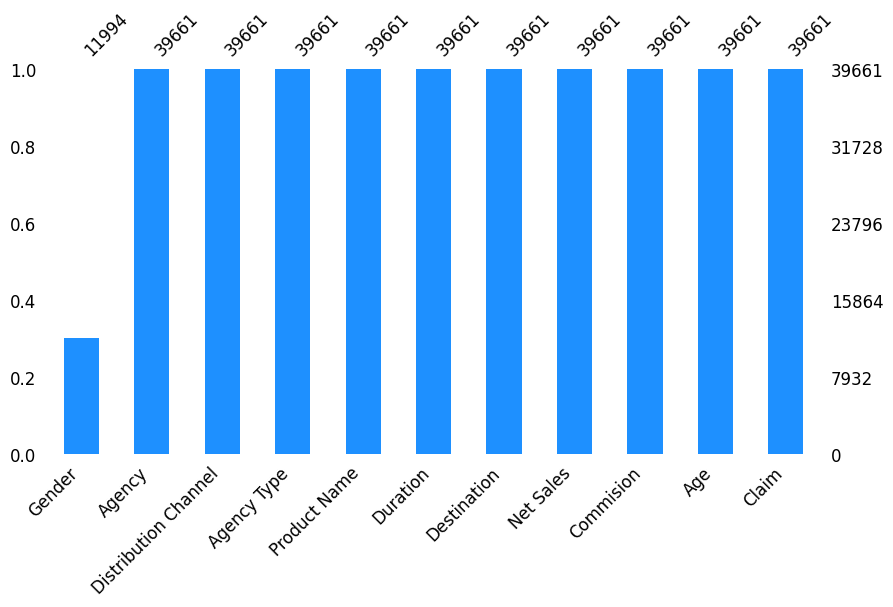

In [36]:
missingno.bar(df,color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);

<Axes: >

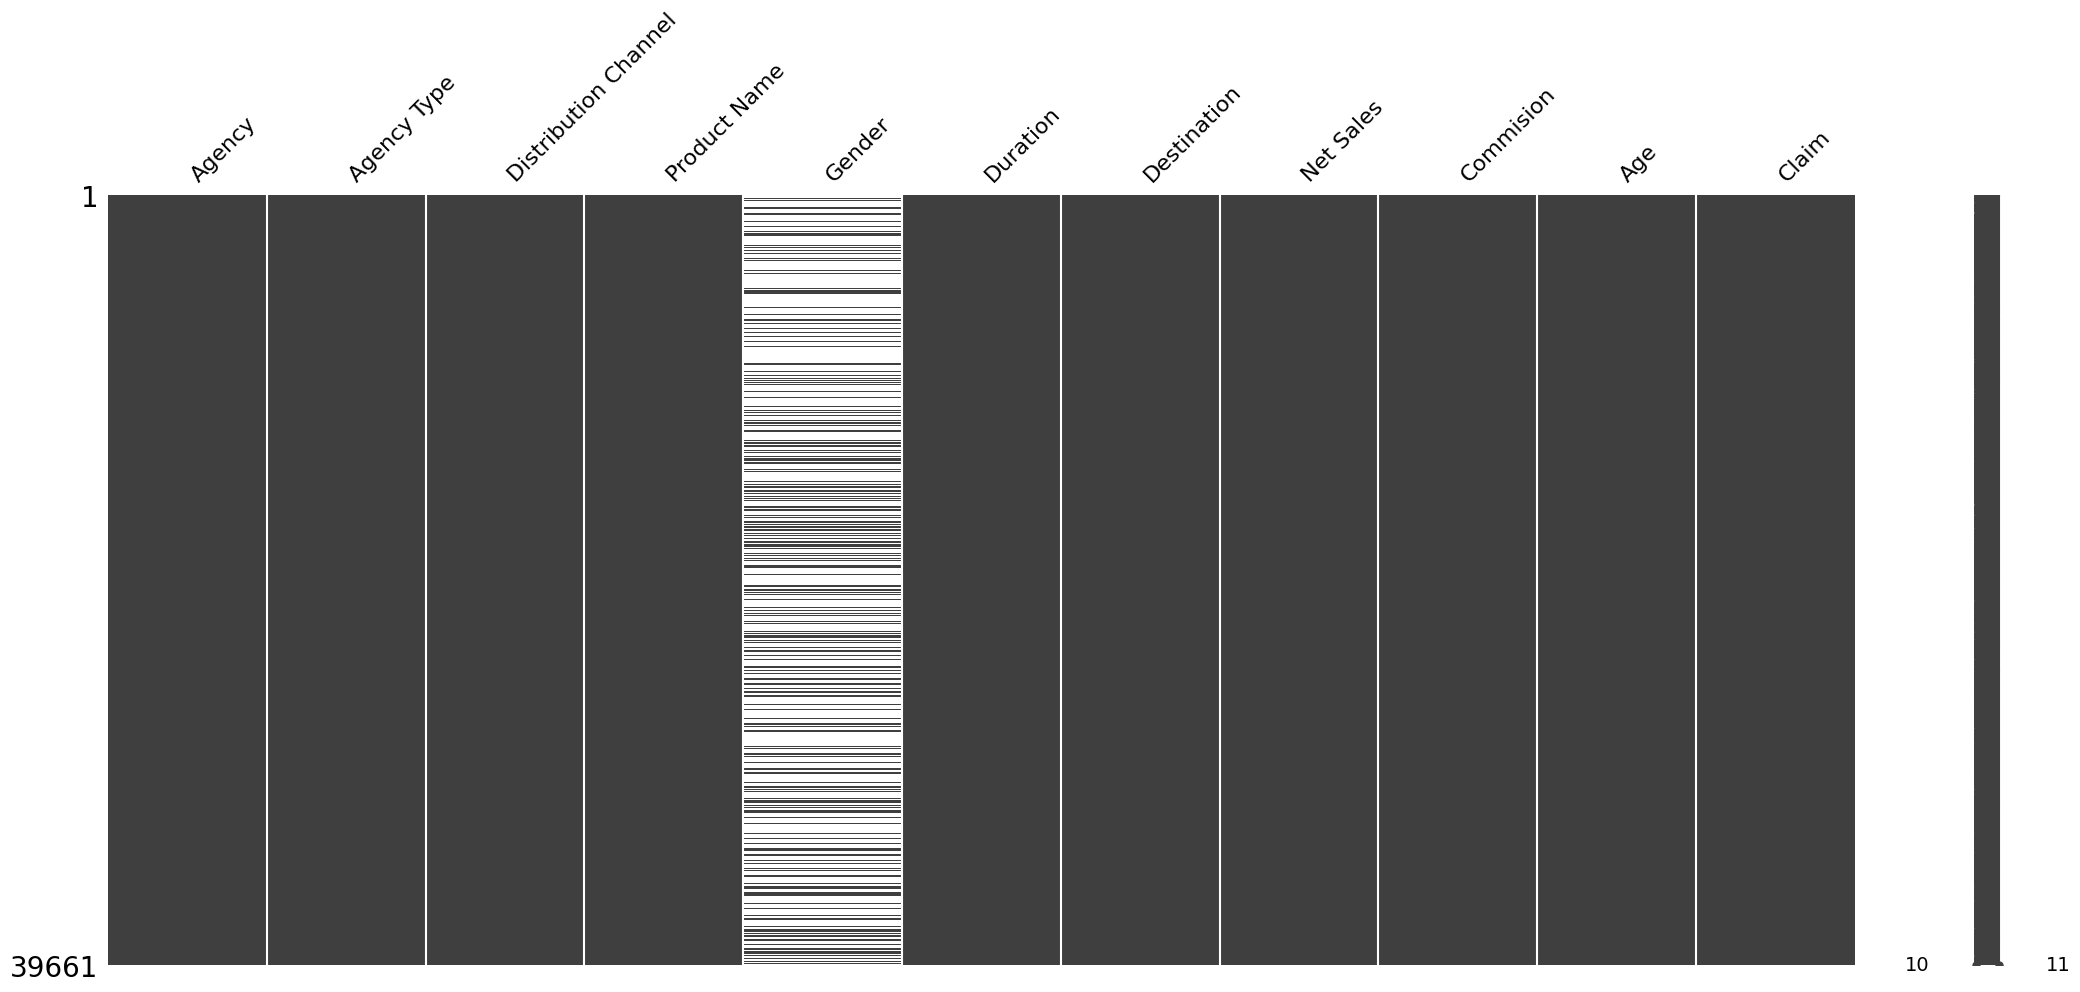

In [37]:
missingno.matrix(df)

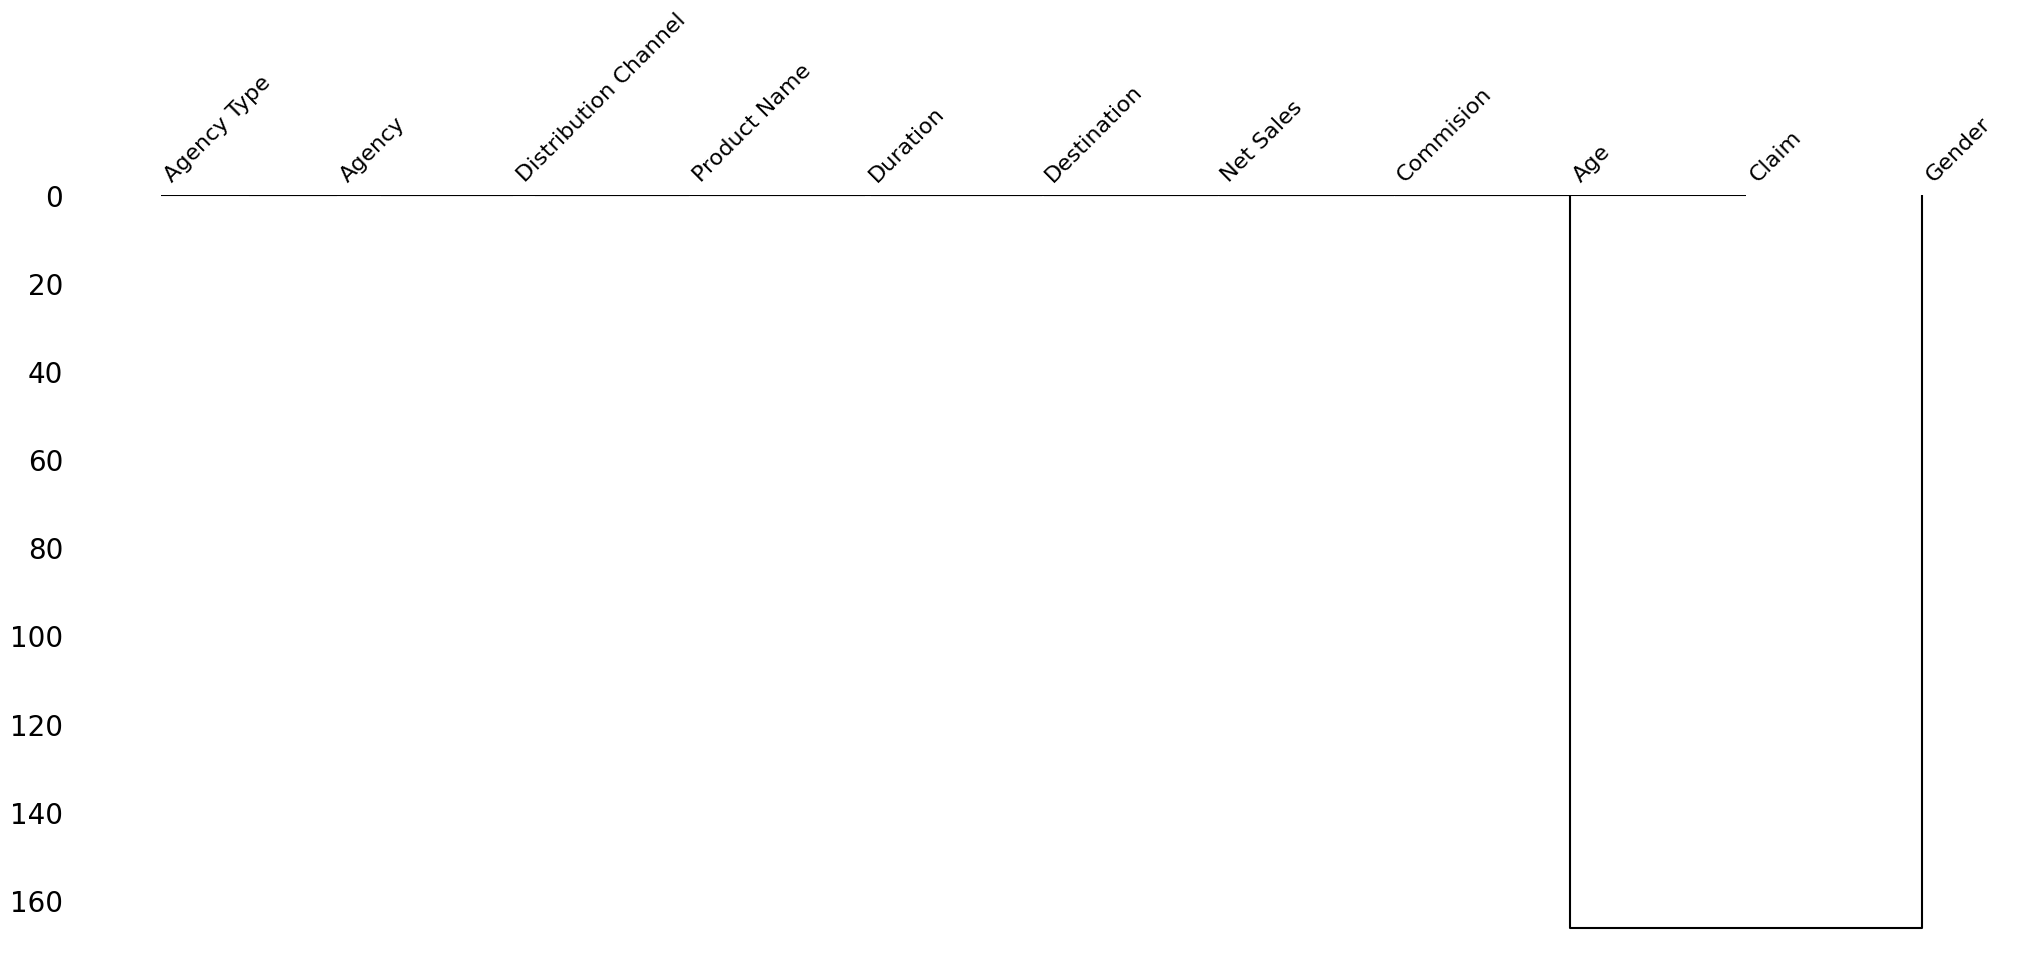

In [38]:
missingno.dendrogram(df)
plt.show()

# Insight dari visualisasi missingno pada data df

1. Kolom 'Gender' memiliki missing value yang sangat tinggi (~70%), terlihat jelas pada grafik bar dan matrix missingno.
    - Hal ini menunjukkan bahwa sebagian besar data pada kolom 'Gender' tidak tersedia, sehingga perlu dipertimbangkan apakah kolom ini akan diimputasi, di-drop, atau digunakan dengan teknik khusus.
2. Kolom-kolom lain seperti 'Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Duration', 'Destination', 'Net Sales', 'Commision', 'Age', dan 'Claim' tidak memiliki missing value.
    - Ini berarti data pada kolom-kolom tersebut relatif lengkap dan dapat langsung digunakan untuk analisis dan pemodelan.
3. Tidak ditemukan pola missing value yang saling berhubungan antar kolom (berdasarkan matrix dan dendrogram missingno).
    - Artinya, missing value pada 'Gender' terjadi secara acak dan tidak terkait dengan kolom lain.
Kesimpulan: Fokus penanganan missing value hanya pada kolom 'Gender', sedangkan kolom lain dapat langsung digunakan.


In [39]:
pd.DataFrame({
    'age_range':['10-19', '20-29', '30-39', '40-49', '50 or above'],
    'missing_values':[
        df[(df['Age']>=10) & (df['Age']<20)]['Gender'].isna().sum(),
        df[(df['Age']>=20) & (df['Age']<30)]['Gender'].isna().sum(),
        df[(df['Age']>=30) & (df['Age']<40)]['Gender'].isna().sum(),
        df[(df['Age']>=40) & (df['Age']<50)]['Gender'].isna().sum(),
        df[(df['Age']>=50)]['Gender'].isna().sum(),
    ]
})

,age_range,missing_values
0,10-19,26
1,20-29,2692
2,30-39,18343
3,40-49,3641
4,50 or above,2965


In [40]:
from scipy.stats import chi2_contingency

# Hitung proporsi klaim untuk masing-masing gender
claim_by_gender = df[df['Gender'].notna()].groupby('Gender')['Claim'].agg(['mean', 'count'])
print("Proporsi klaim berdasarkan gender:")
display(claim_by_gender)

# Uji statistik proporsi klaim antara laki-laki dan perempuan (uji chi-square)

# Buat tabel kontingensi
contingency_table = pd.crosstab(df['Gender'], df['Claim'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"\nHasil uji chi-square:")
print(f"Chi2 statistic: {chi2:.4f}, p-value: {p:.4f}")

if p < 0.05:
    print("Terdapat perbedaan signifikan proporsi klaim antara laki-laki dan perempuan.")
else:
    print("Tidak terdapat perbedaan signifikan proporsi klaim antara laki-laki dan perempuan.")

Proporsi klaim berdasarkan gender:


,mean,count
Gender,,
F,0.042736,5920
M,0.036220,6074



Hasil uji chi-square:
Chi2 statistic: 3.1910, p-value: 0.0740
Tidak terdapat perbedaan signifikan proporsi klaim antara laki-laki dan perempuan.


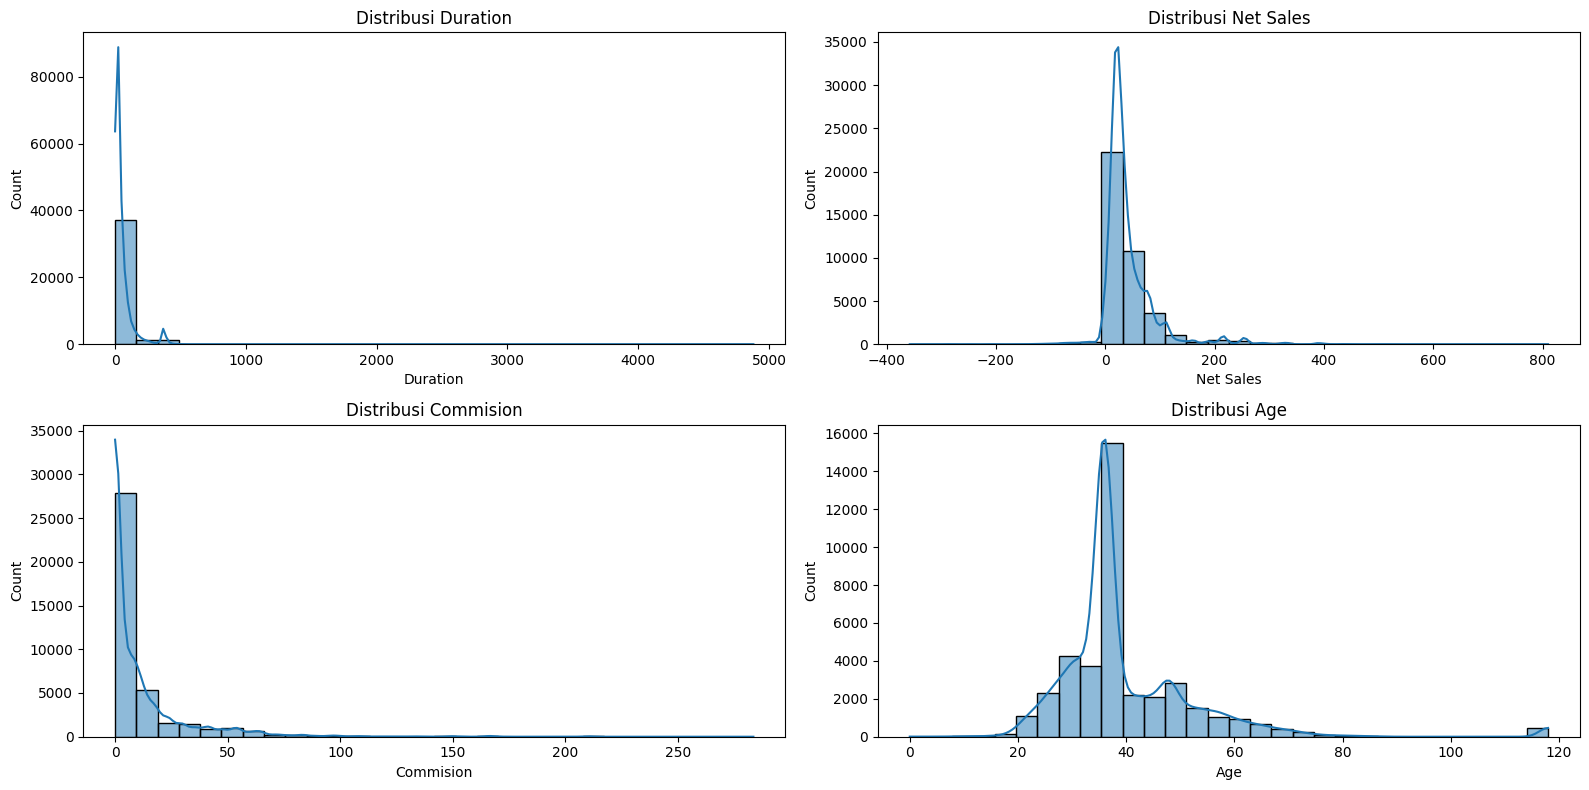

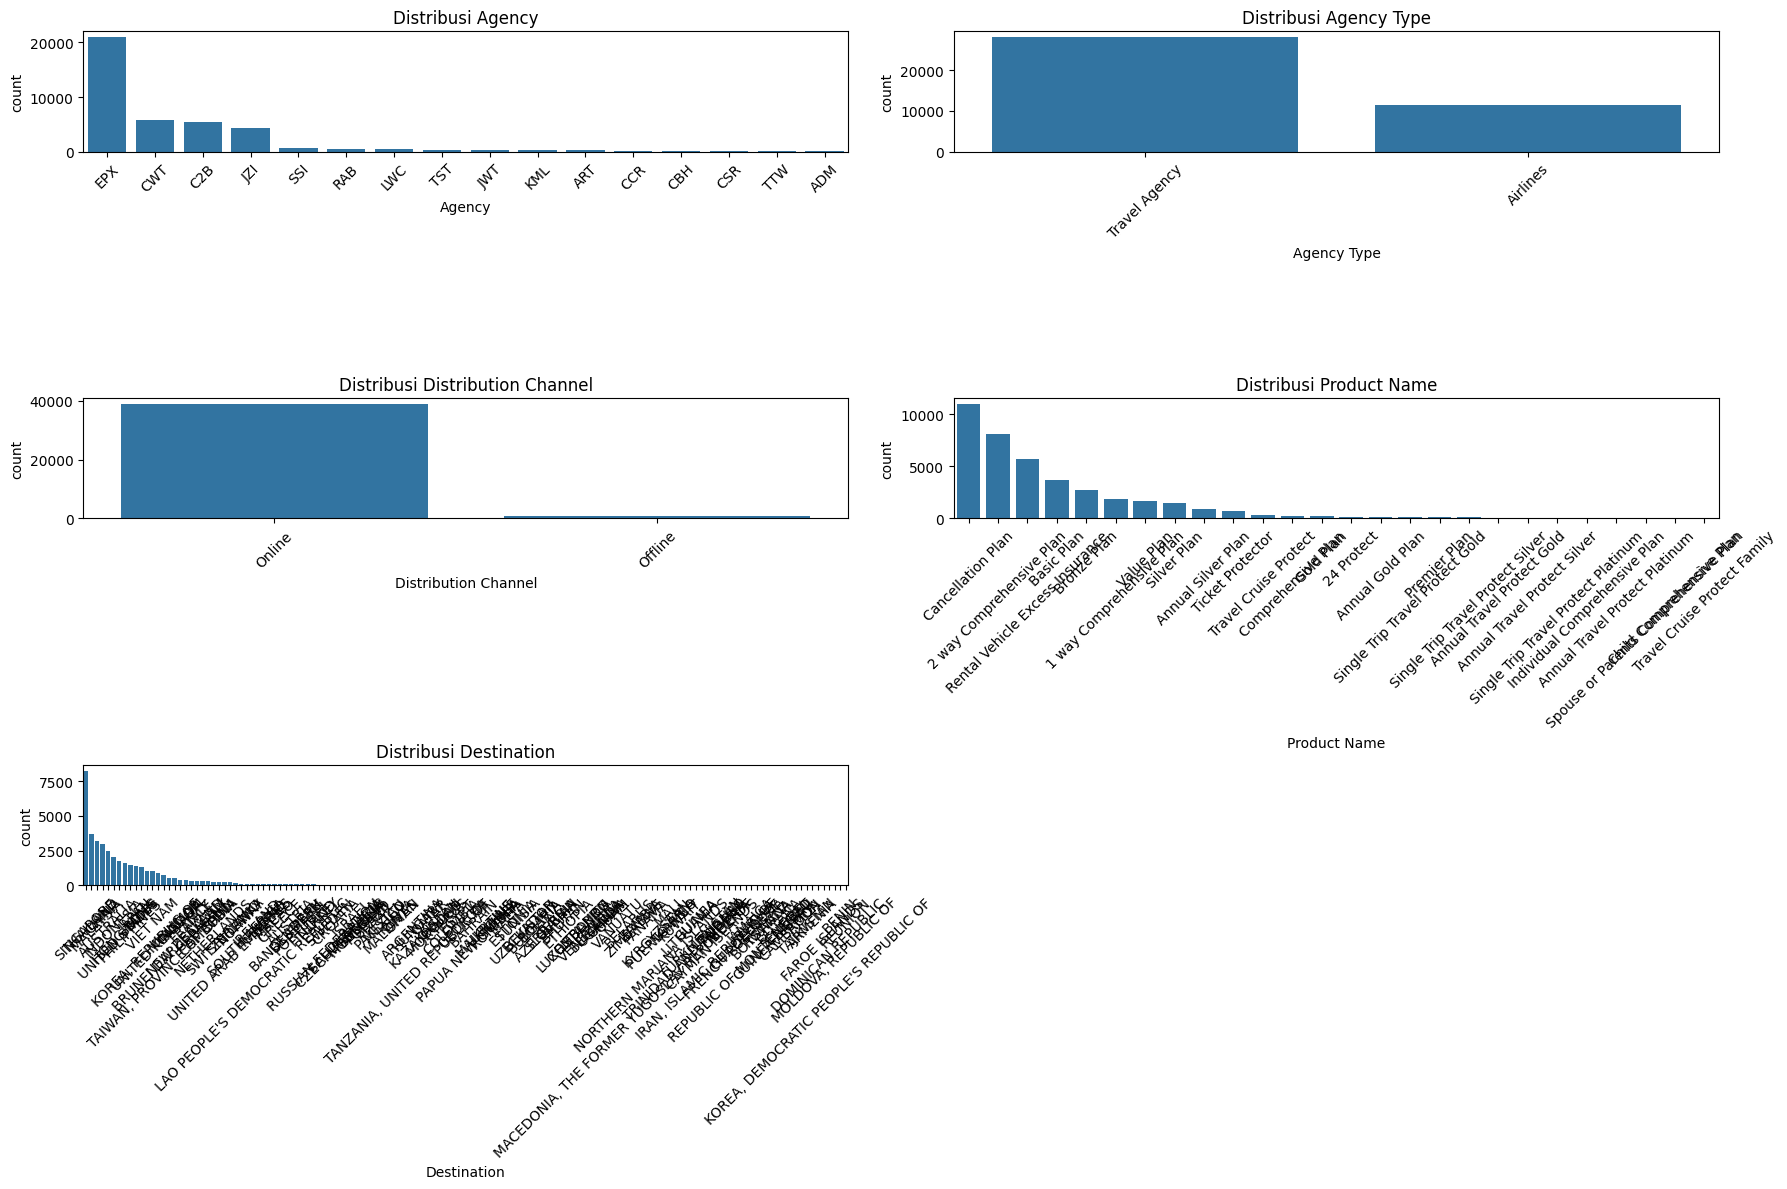

In [41]:
# Definisikan kolom numerik dan kategorikal
numerical_cols = ['Duration', 'Net Sales', 'Commision', 'Age']
categorical_cols = ['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Destination']

# 1. Distribusi fitur numerik
plt.figure(figsize=(16, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribusi {col}')
plt.tight_layout()
plt.show()

# 2. Distribusi fitur kategorikal
plt.figure(figsize=(18, 12))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 2, i)
    order = df[col].value_counts().index
    sns.countplot(x=col, data=df, order=order)
    plt.xticks(rotation=45)
    plt.title(f'Distribusi {col}')
plt.tight_layout()
plt.show()


# Insight dari Visualisasi Data

1. **Distribusi Fitur Numerik**
    - Fitur numerik seperti `Duration`, `Net Sales`, `Commision`, dan `Age` menunjukkan adanya outlier, terutama pada nilai yang sangat tinggi.
    - Sebagian besar data berada pada rentang nilai yang wajar, sementara outlier hanya dimiliki oleh sebagian kecil data.

2. **Distribusi Fitur Kategorikal**
    - Fitur kategorikal seperti `Agency`, `Agency Type`, `Distribution Channel`, `Product Name`, dan `Destination` memiliki distribusi yang bervariasi, dengan beberapa kategori mendominasi.
    - Hal ini menunjukkan adanya kecenderungan tertentu dalam pemilihan produk atau destinasi perjalanan oleh pelanggan.


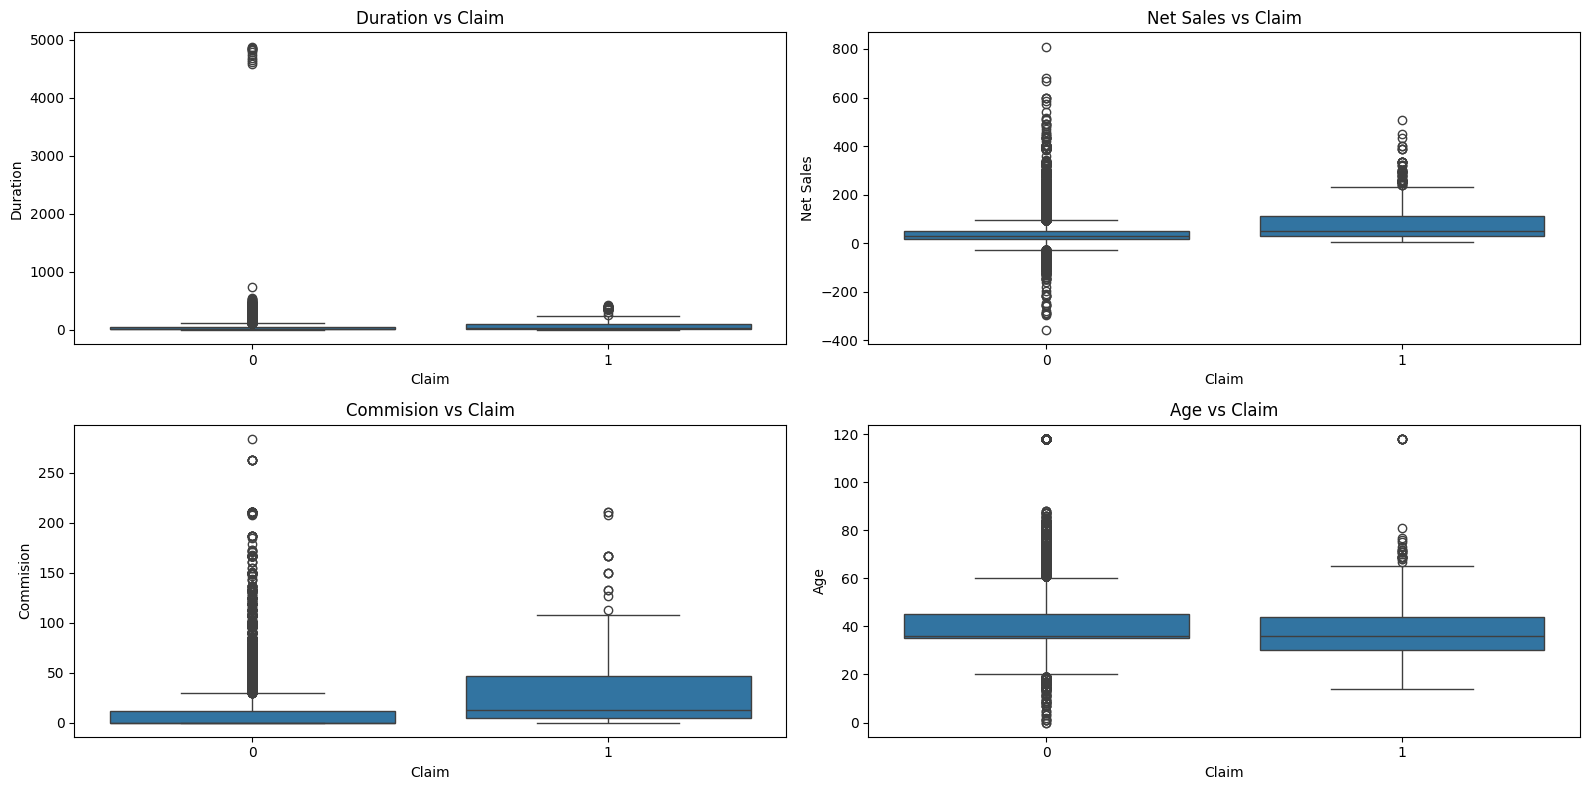

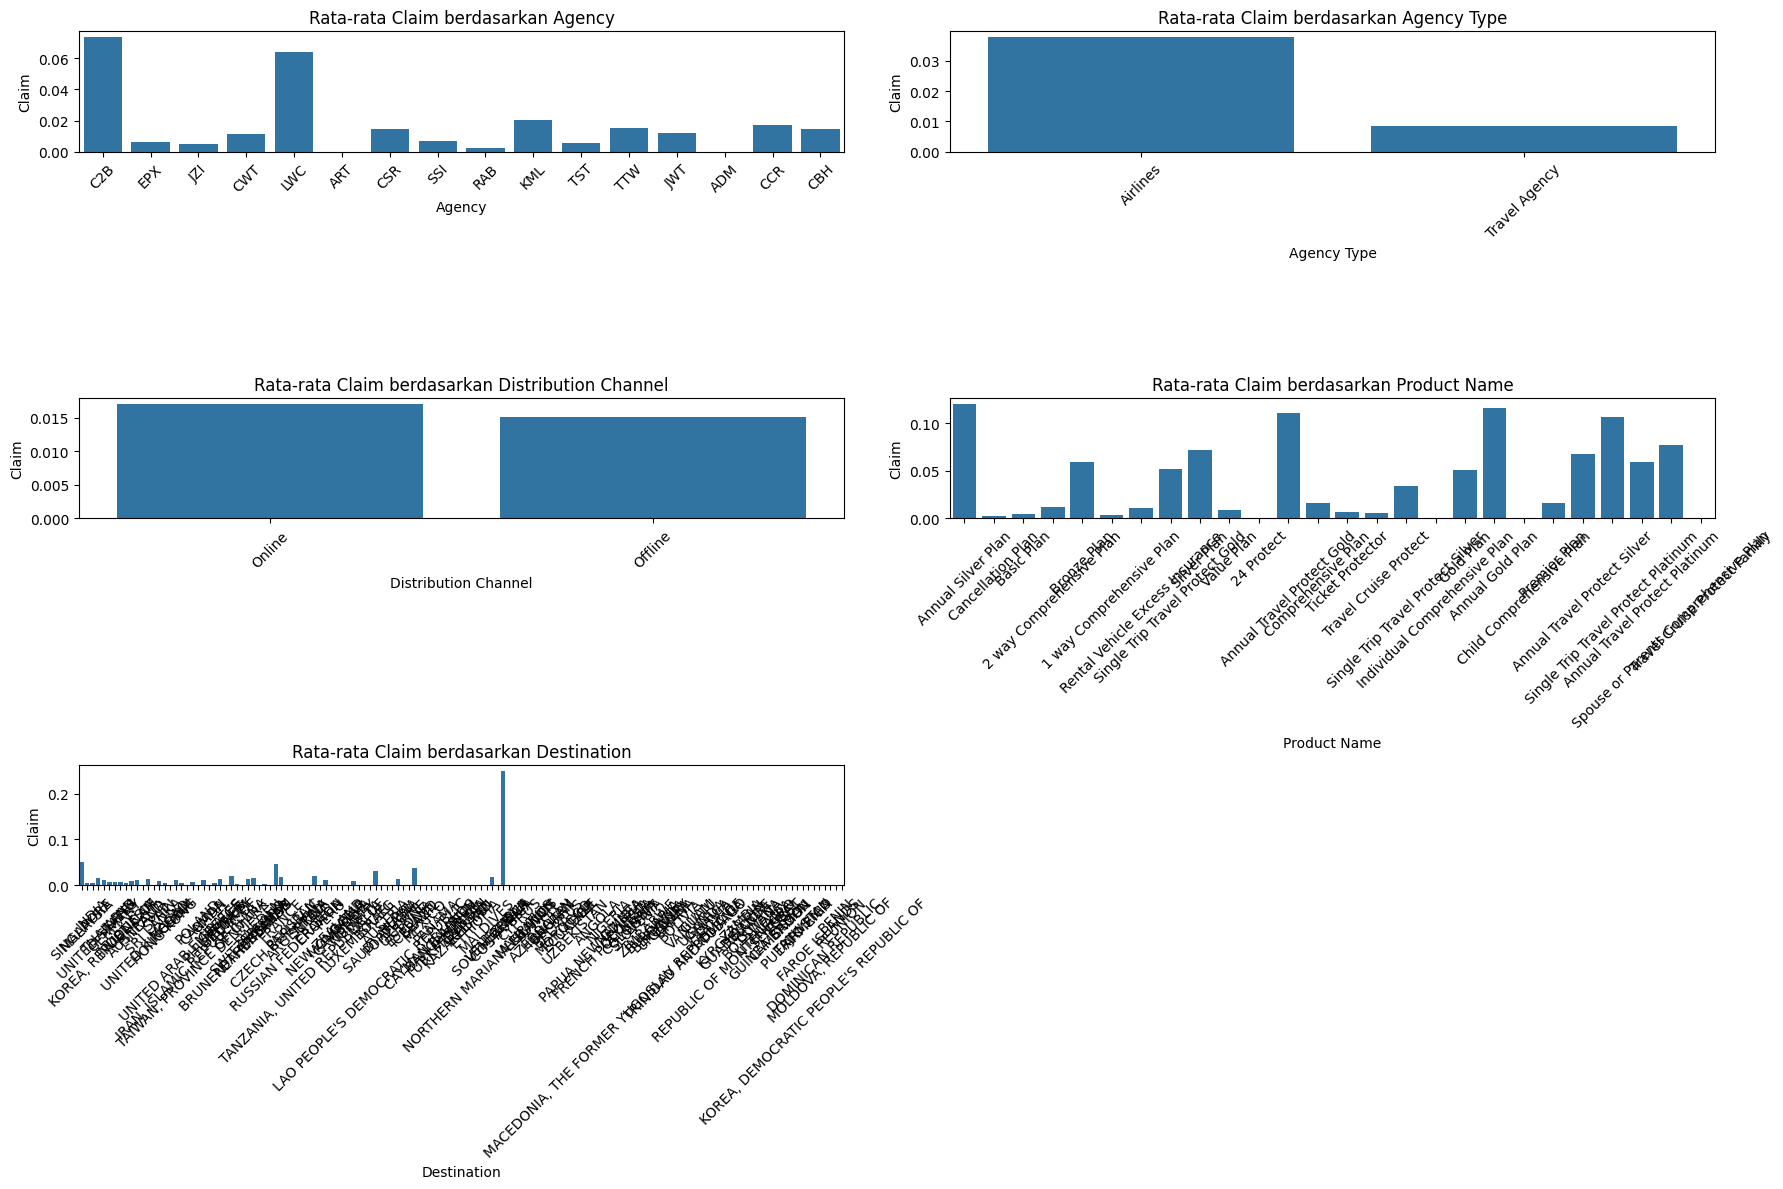

In [42]:

# 3. Hubungan fitur numerik dengan target
plt.figure(figsize=(16, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='Claim', y=col, data=df)
    plt.title(f'{col} vs Claim')
plt.tight_layout()
plt.show()

# 4. Hubungan fitur kategorikal dengan target
plt.figure(figsize=(18, 12))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 2, i)
    sns.barplot(x=col, y='Claim', data=df, ci=None, estimator=np.mean)
    plt.xticks(rotation=45)
    plt.title(f'Rata-rata Claim berdasarkan {col}')
plt.tight_layout()
plt.show()

# Analisis dan Insight Hubungan Fitur Numerik & Kategorikal dengan Target (`Claim`)

## 1. Fitur Numerik vs Target
- **Duration, Net Sales, Commision, Age**:
    - Dari visualisasi boxplot dan statistik deskriptif, terdapat perbedaan distribusi antara data yang mengajukan klaim (`Claim=1`) dan tidak (`Claim=0`).
    - Rata-rata dan median pada fitur numerik untuk klaim cenderung berbeda, meskipun perbedaannya tidak selalu besar.
    - Outlier pada fitur-fitur ini dapat mempengaruhi model, sehingga perlu penanganan khusus (misal: capping atau transformasi).
    - **Insight:** Beberapa fitur numerik, seperti `Duration` dan `Net Sales`, menunjukkan kecenderungan bahwa polis dengan durasi lebih lama atau nilai penjualan lebih tinggi sedikit lebih sering mengajukan klaim.

## 2. Fitur Kategorikal vs Target
- **Agency, Agency Type, Distribution Channel, Product Name, Destination**:
    - Rata-rata klaim bervariasi antar kategori. Misalnya, beberapa `Agency` atau `Product Name` memiliki proporsi klaim yang lebih tinggi dibandingkan kategori lain.
    - Distribusi target (`Claim`) tidak merata di seluruh kategori, menandakan adanya pengaruh kategori tertentu terhadap kemungkinan klaim.
    - **Insight:** Kategori pada fitur-fitur seperti `Product Name` dan `Destination` dapat menjadi prediktor penting, karena terdapat kategori yang secara signifikan lebih sering dikaitkan dengan klaim.

## 3. Kesimpulan Umum
- **Fitur numerik** memberikan informasi tentang karakteristik polis dan pelanggan yang berpotensi mengajukan klaim.
- **Fitur kategorikal** membantu mengidentifikasi kelompok pelanggan atau produk yang lebih berisiko.
- Kombinasi kedua tipe fitur ini penting untuk membangun model prediksi klaim yang akurat.

In [ ]:
# Menghapus data dengan nilai kosong (Missing Values) dan menghapus kolom Gender
df = df.dropna().reset_index(drop=True)
df = df.drop(['Gender'], axis=1)
df

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision,Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.00,57,0
1,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.70,26,0
2,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.00,28,0
3,JZI,Airlines,Online,Basic Plan,4,THAILAND,22.0,7.70,39,0
4,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.00,27,0
...,...,...,...,...,...,...,...,...,...,...
11989,LWC,Travel Agency,Online,Single Trip Travel Protect Silver,11,CHINA,49.5,32.18,84,0
11990,JZI,Airlines,Online,Basic Plan,13,THAILAND,22.0,7.70,42,0
11991,JZI,Airlines,Online,Value Plan,11,UNITED KINGDOM,87.0,30.45,65,0
11992,TST,Travel Agency,Offline,Travel Cruise Protect,94,THAILAND,30.0,10.50,0,0


# Penjelasan mengapa kolom 'Gender' dihapus

"""
Kolom 'Gender' dihapus dari dataset karena memiliki persentase missing value yang sangat tinggi (sekitar 70%). 
Analisis statistik dan uji chi-square juga menunjukkan bahwa tidak ada perbedaan signifikan proporsi klaim antara laki-laki dan perempuan.
Jika kolom dengan missing value sebesar ini tetap digunakan, akan menambah bias/noise pada model, terutama jika diimputasi sembarangan.
Oleh karena itu, untuk menjaga kualitas data dan performa model, kolom 'Gender' dihapus dari dataset.
"""


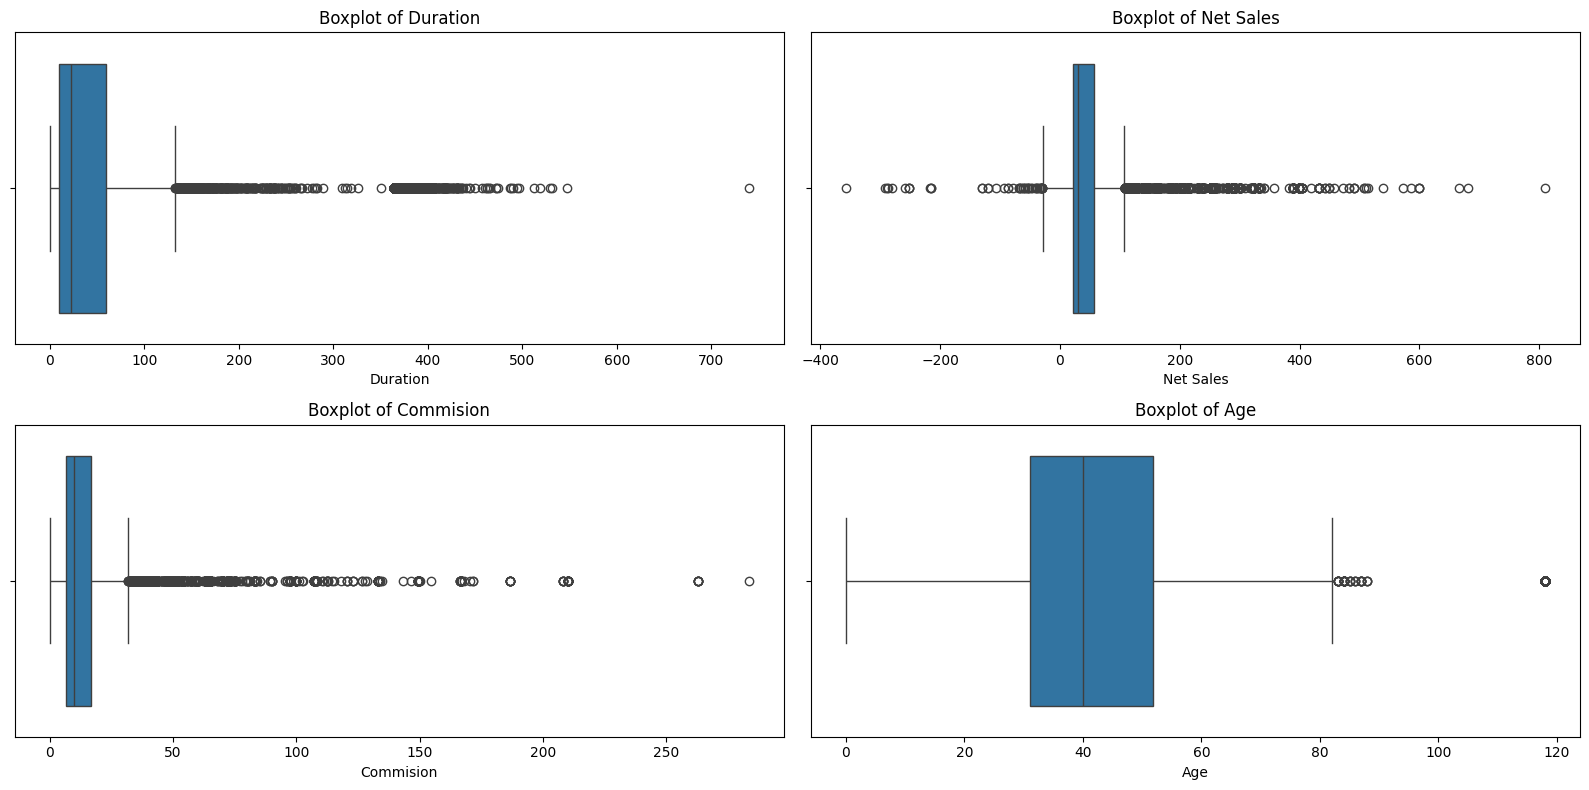

In [44]:
# Visualisasi boxplot untuk mendeteksi outlier pada fitur numerik
numerical_cols = ['Duration', 'Net Sales', 'Commision', 'Age']

plt.figure(figsize=(16, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# Insight dari Visualisasi Boxplot Fitur Numerik

1. **Duration**
    - Terdapat beberapa outlier pada fitur `Duration`, terlihat dari adanya titik-titik yang jauh di atas boxplot. Hal ini menunjukkan bahwa sebagian kecil perjalanan memiliki durasi yang jauh lebih lama dibandingkan mayoritas data.
    - Mayoritas data memiliki durasi perjalanan yang relatif pendek.

2. **Net Sales**
    - Distribusi `Net Sales` menunjukkan adanya outlier, baik pada nilai yang sangat tinggi maupun rendah (termasuk kemungkinan nilai negatif).
    - Sebagian besar data berada pada rentang nilai yang lebih kecil, sedangkan nilai ekstrim hanya dimiliki oleh sedikit data.

3. **Commision**
    - Fitur `Commision` juga memiliki beberapa outlier dengan nilai yang jauh lebih tinggi dari mayoritas data.
    - Sebagian besar komisi berada pada rentang yang relatif kecil.

4. **Age**
    - Terdapat beberapa outlier pada fitur `Age`, namun distribusi usia pelanggan cenderung lebih merata dibandingkan fitur numerik lainnya.
    - Mayoritas pelanggan berada pada rentang usia dewasa hingga paruh baya.

**Kesimpulan:**  
Seluruh fitur numerik memiliki outlier, terutama pada `Duration`, `Net Sales`, dan `Commision`. Perlu dipertimbangkan penanganan outlier (misal: capping, transformasi, atau analisis lebih lanjut) agar tidak mempengaruhi performa model secara signifikan.

In [45]:
outliers = df[((df['Duration'] > 600) | (df['Age'] > 100))]
outliers

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision,Age,Claim
28,ART,Airlines,Online,Value Plan,7,MALAYSIA,29.0,10.15,118,0
104,JWT,Airlines,Online,Value Plan,12,INDIA,39.0,15.60,118,0
110,JWT,Airlines,Online,Value Plan,6,INDIA,39.0,15.60,118,0
201,JWT,Airlines,Online,Value Plan,76,INDIA,100.0,40.00,118,0
256,ART,Airlines,Online,Value Plan,137,HONG KONG,61.0,21.35,118,0
...,...,...,...,...,...,...,...,...,...,...
11866,JWT,Airlines,Online,Value Plan,25,INDIA,31.0,12.40,118,0
11869,JWT,Airlines,Online,Value Plan,10,INDIA,50.0,20.00,118,1
11893,JWT,Airlines,Online,Value Plan,83,INDIA,180.0,72.00,118,0
11935,JWT,Airlines,Online,Value Plan,42,INDIA,31.0,12.40,118,0


In [46]:
# Hitung persentase outlier dari data
persentase_outlier = len(outliers) / len(df) * 100
print(f"Persentase outlier: {persentase_outlier:.2f}%")

Persentase outlier: 3.19%


In [47]:
# Menghapus baris-baris outlier yang sudah didefinisikan pada variabel 'outliers'
df = df.drop(outliers.index).reset_index(drop=True)
df

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision,Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.00,57,0
1,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.70,26,0
2,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.00,28,0
3,JZI,Airlines,Online,Basic Plan,4,THAILAND,22.0,7.70,39,0
4,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.00,27,0
...,...,...,...,...,...,...,...,...,...,...
11606,LWC,Travel Agency,Online,Single Trip Travel Protect Silver,11,CHINA,49.5,32.18,84,0
11607,JZI,Airlines,Online,Basic Plan,13,THAILAND,22.0,7.70,42,0
11608,JZI,Airlines,Online,Value Plan,11,UNITED KINGDOM,87.0,30.45,65,0
11609,TST,Travel Agency,Offline,Travel Cruise Protect,94,THAILAND,30.0,10.50,0,0


,Duration,Net Sales,Commision,Age
count,11611.000000,11611.000000,11611.000000,11611.000000
mean,70.107743,57.615161,18.326396,41.311946
std,113.462157,74.508204,25.128509,13.739524
min,0.000000,-357.500000,0.000000,0.000000
25%,10.000000,22.000000,6.630000,30.000000
50%,22.000000,30.000000,9.570000,39.000000
75%,59.000000,54.500000,16.250000,50.000000
max,547.000000,682.000000,262.760000,88.000000



Distribusi nilai unik pada kolom 'Agency':
Agency
C2B    5492
JZI    4239
LWC     453
TST     341
RAB     325
KML     249
ART     190
CCR      96
CBH      69
CSR      68
TTW      66
ADM      20
CWT       3
Name: count, dtype: int64
----------------------------------------

Distribusi nilai unik pada kolom 'Agency Type':
Agency Type
Airlines         10246
Travel Agency     1365
Name: count, dtype: int64
----------------------------------------

Distribusi nilai unik pada kolom 'Distribution Channel':
Distribution Channel
Online     10966
Offline      645
Name: count, dtype: int64
----------------------------------------

Distribusi nilai unik pada kolom 'Product Name':
Product Name
Basic Plan                              3652
Bronze Plan                             2718
Silver Plan                             1504
Value Plan                              1105
Annual Silver Plan                       896
Travel Cruise Protect                    340
Gold Plan                              

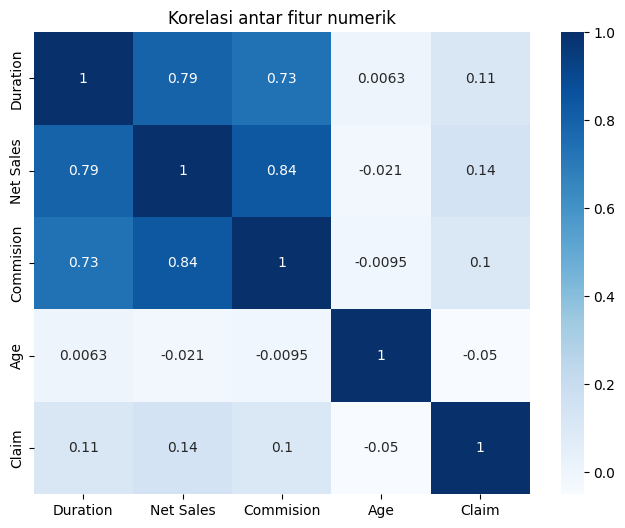

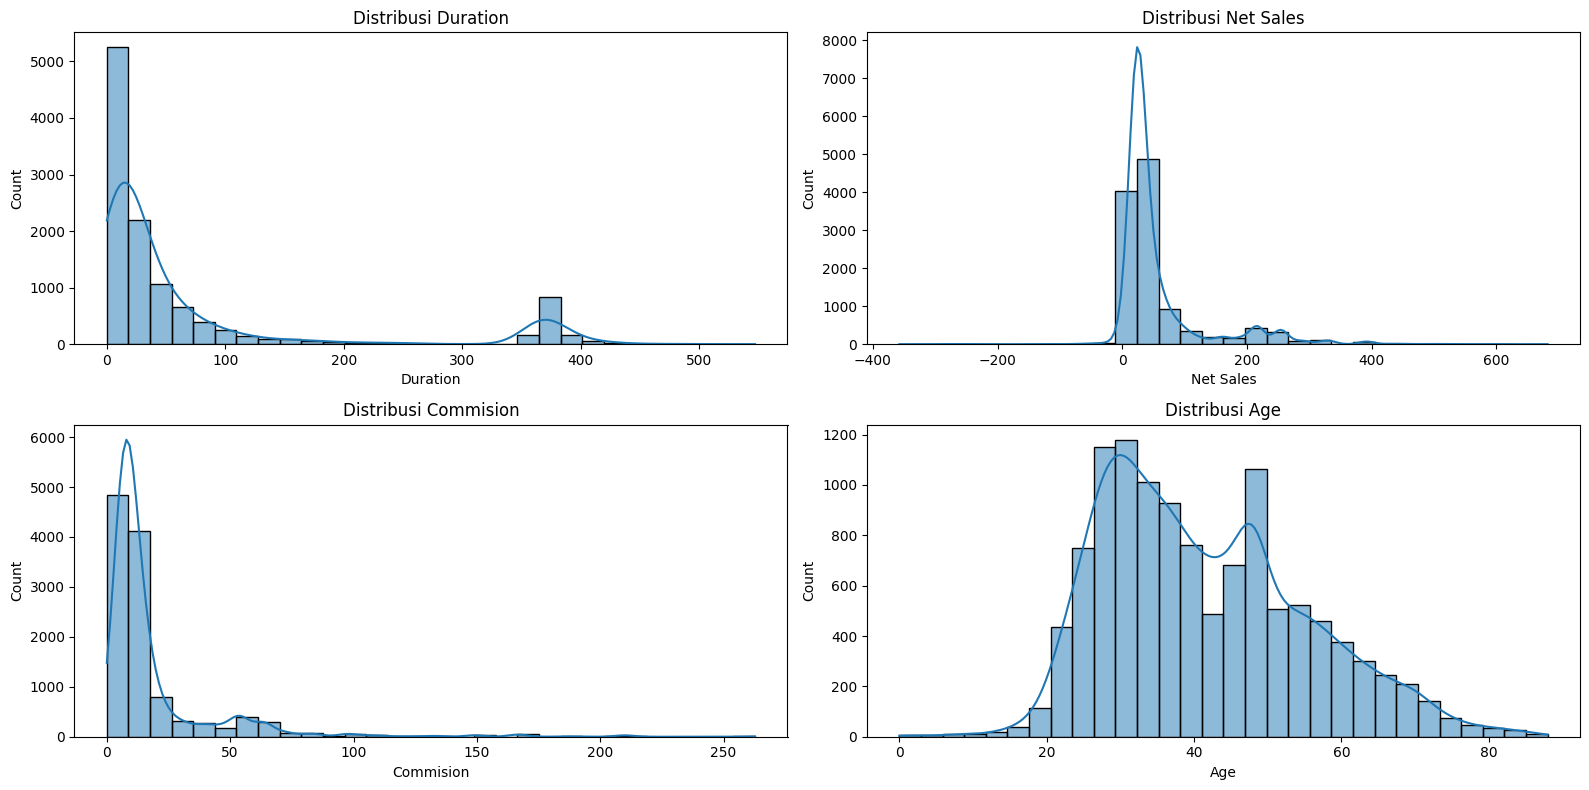

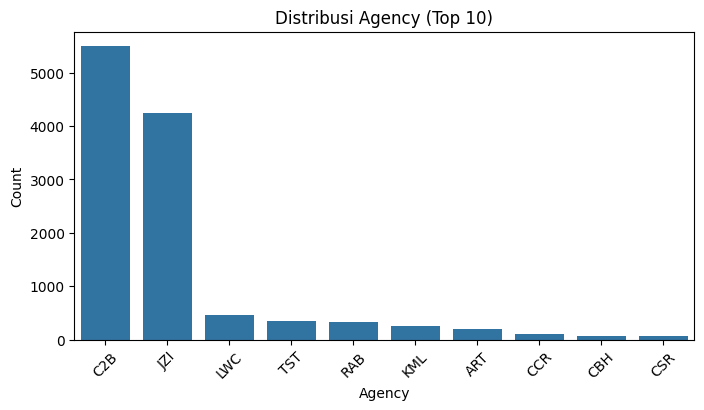

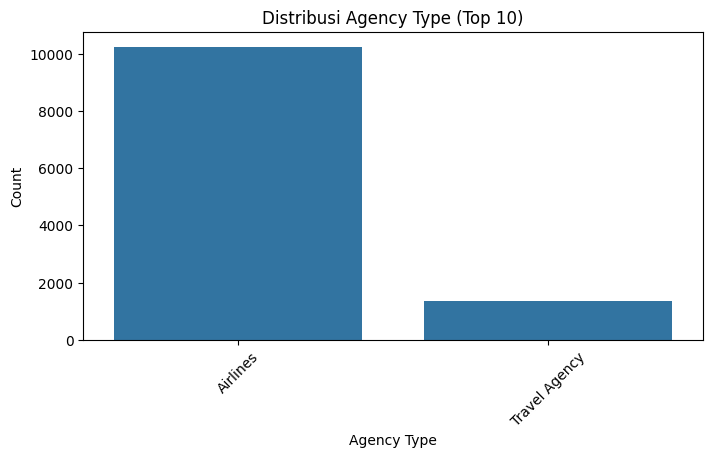

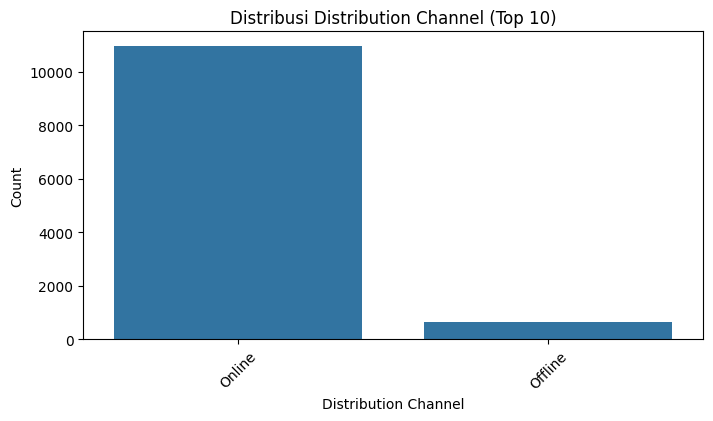

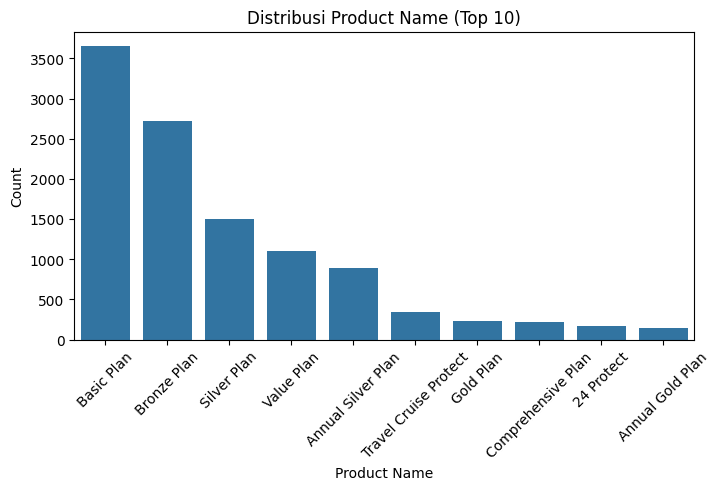

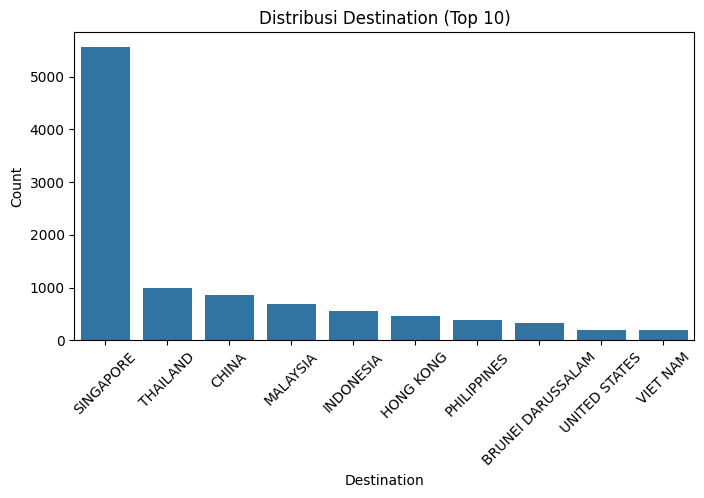

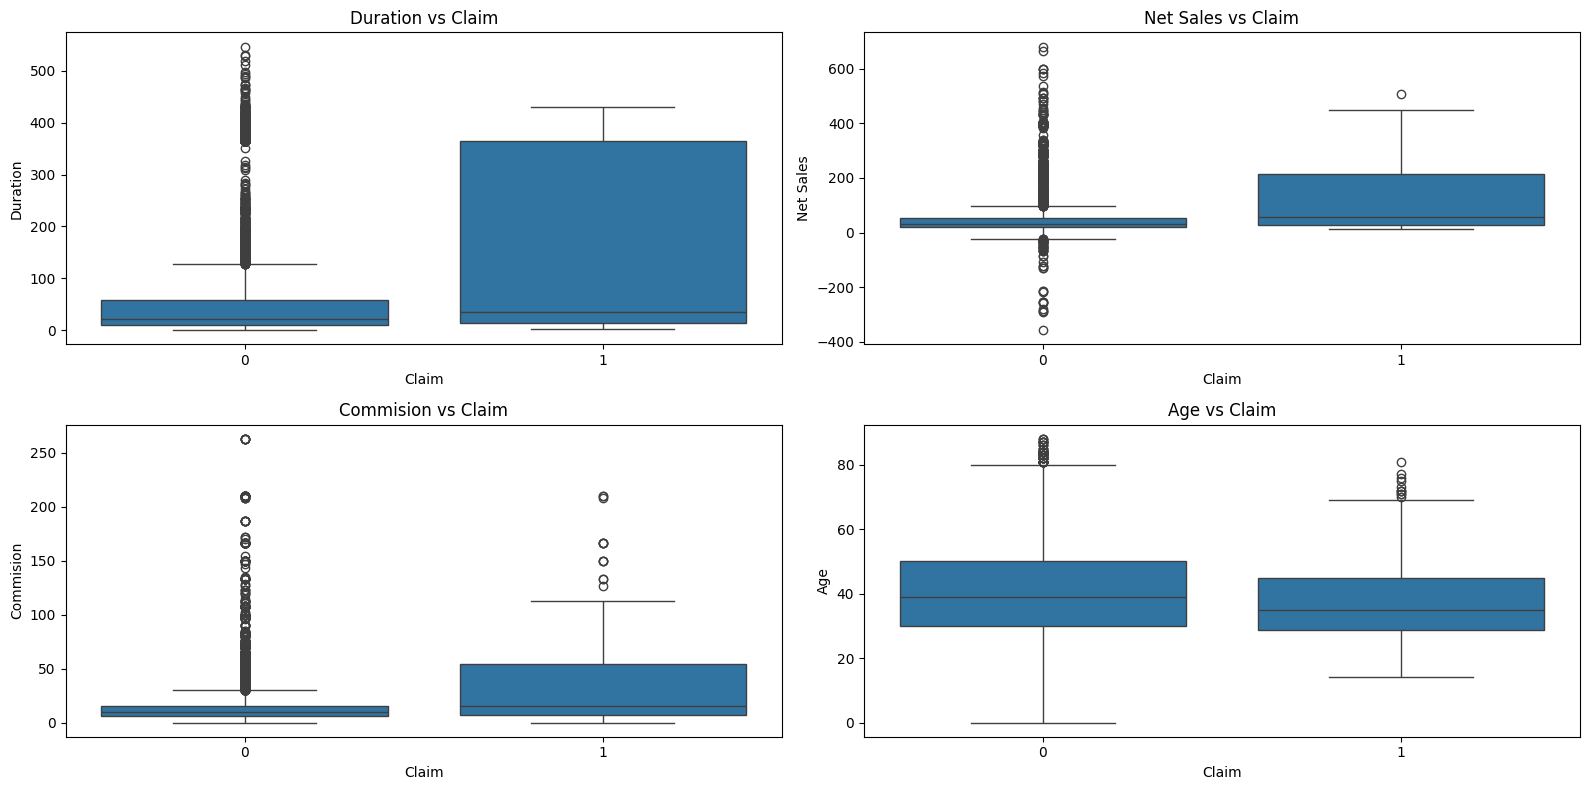

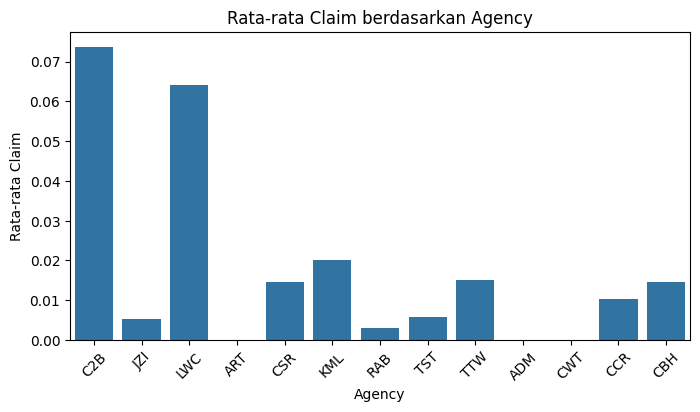

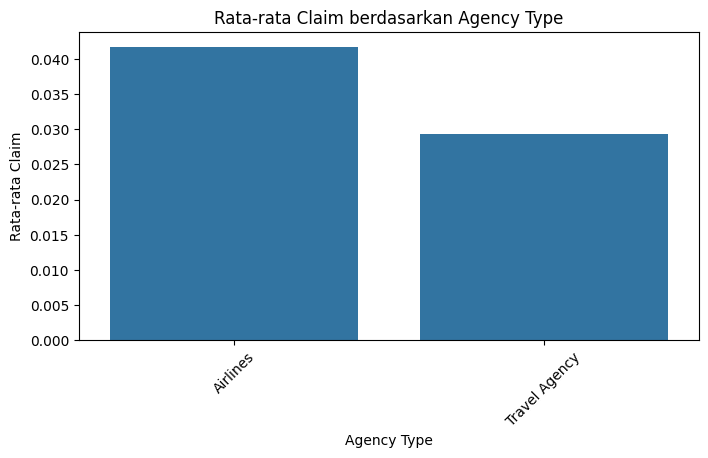

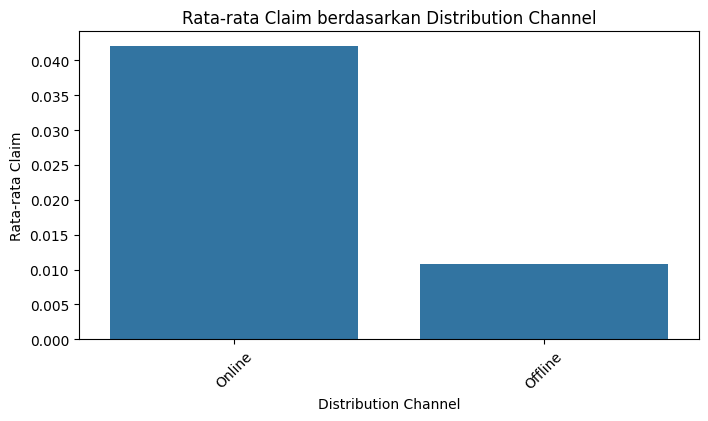

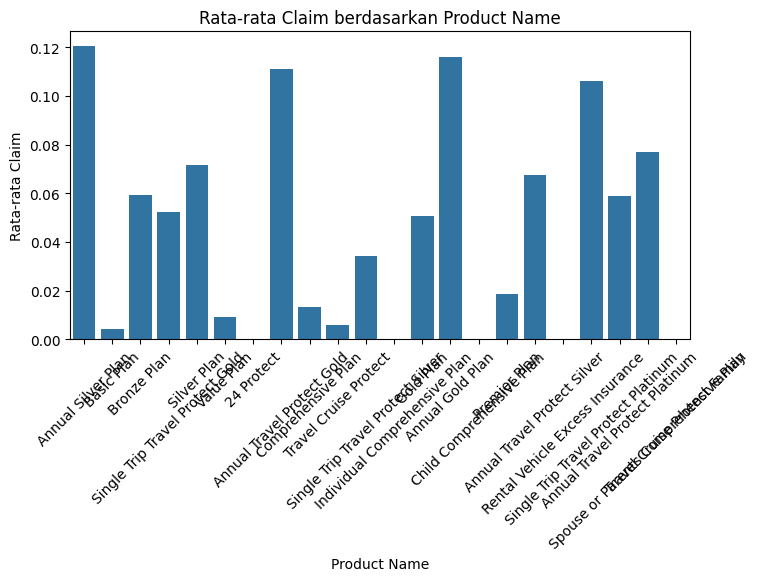

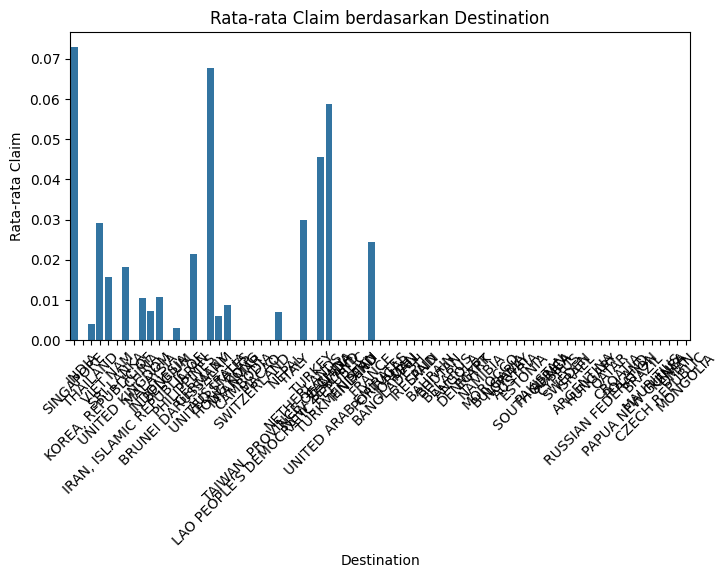

In [48]:
# EDA: Statistik Deskriptif dan Visualisasi Data

# 1. Statistik deskriptif fitur numerik
display(df[numerical_cols].describe())

# 2. Statistik fitur kategorikal
for col in categorical_cols:
    if col in df.columns:
        print(f"\nDistribusi nilai unik pada kolom '{col}':")
        print(df[col].value_counts(dropna=False))
        print("-" * 40)

# 3. Korelasi antar fitur numerik
plt.figure(figsize=(8, 6))
sns.heatmap(df[numerical_cols + ['Claim']].corr(), annot=True, cmap='Blues')
plt.title('Korelasi antar fitur numerik')
plt.show()

# 4. Visualisasi distribusi fitur numerik
plt.figure(figsize=(16, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribusi {col}')
plt.tight_layout()
plt.show()

# 5. Visualisasi distribusi fitur kategorikal (top 10 kategori jika terlalu banyak)
for col in categorical_cols:
    if col in df.columns:
        plt.figure(figsize=(8, 4))
        vc = df[col].value_counts(dropna=False)
        vc = vc[:10] if len(vc) > 10 else vc
        sns.barplot(x=vc.index.astype(str), y=vc.values)
        plt.title(f'Distribusi {col} (Top 10)')
        plt.xticks(rotation=45)
        plt.ylabel('Count')
        plt.show()

# 6. Visualisasi hubungan fitur numerik dengan target
plt.figure(figsize=(16, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='Claim', y=col, data=df)
    plt.title(f'{col} vs Claim')
plt.tight_layout()
plt.show()

# 7. Visualisasi hubungan fitur kategorikal dengan target
for col in categorical_cols:
    if col in df.columns:
        plt.figure(figsize=(8, 4))
        sns.barplot(x=col, y='Claim', data=df, ci=None, estimator=np.mean)
        plt.title(f'Rata-rata Claim berdasarkan {col}')
        plt.xticks(rotation=45)
        plt.ylabel('Rata-rata Claim')
        plt.show()

# Insight dari Visualisasi Data

1. **Distribusi Fitur Numerik**
    - Fitur numerik seperti `Duration`, `Net Sales`, `Commision`, dan `Age` menunjukkan adanya outlier, terutama pada nilai yang sangat tinggi.
    - Sebagian besar data berada pada rentang nilai yang wajar, sementara outlier hanya dimiliki oleh sebagian kecil data.

2. **Distribusi Fitur Kategorikal**
    - Fitur kategorikal seperti `Agency`, `Agency Type`, `Distribution Channel`, `Product Name`, dan `Destination` memiliki distribusi yang bervariasi, dengan beberapa kategori mendominasi.
    - Hal ini menunjukkan adanya kecenderungan tertentu dalam pemilihan produk atau destinasi perjalanan oleh pelanggan.

3. **Hubungan Fitur Numerik dengan Target (`Claim`)**
    - Terdapat perbedaan distribusi pada beberapa fitur numerik antara data yang mengajukan klaim dan yang tidak, meskipun perbedaannya tidak selalu signifikan.
    - Hal ini mengindikasikan bahwa beberapa fitur numerik dapat berkontribusi dalam prediksi klaim.

4. **Hubungan Fitur Kategorikal dengan Target (`Claim`)**
    - Rata-rata klaim bervariasi antar kategori, misalnya pada jenis produk asuransi atau destinasi tertentu.
    - Beberapa kategori memiliki proporsi klaim yang lebih tinggi, sehingga dapat menjadi fitur penting dalam pemodelan.

**Kesimpulan Umum:**  
Visualisasi data membantu mengidentifikasi adanya outlier pada fitur numerik dan variasi distribusi pada fitur kategorikal. Hubungan antara fitur-fitur tersebut dengan target (`Claim`) menunjukkan adanya pola yang dapat dimanfaatkan untuk membangun model prediksi klaim asuransi perjalanan. Penanganan outlier dan pemilihan fitur yang tepat akan meningkatkan performa model.

# Kesimpulan dari Visualisasi Data

1. **Distribusi Fitur Numerik**
    - Fitur numerik seperti `Duration`, `Net Sales`, `Commision`, dan `Age` menunjukkan adanya outlier, terutama pada nilai yang sangat tinggi.
    - Mayoritas data berada pada rentang nilai yang wajar, sementara outlier hanya dimiliki oleh sebagian kecil data.

2. **Distribusi Fitur Kategorikal**
    - Fitur kategorikal seperti `Agency`, `Agency Type`, `Distribution Channel`, `Product Name`, dan `Destination` memiliki distribusi yang bervariasi, dengan beberapa kategori mendominasi.
    - Hal ini menunjukkan adanya kecenderungan tertentu dalam pemilihan produk atau destinasi perjalanan oleh pelanggan.

3. **Hubungan Fitur Numerik dengan Target (`Claim`)**
    - Terdapat perbedaan distribusi pada beberapa fitur numerik antara data yang mengajukan klaim dan yang tidak, meskipun perbedaannya tidak selalu signifikan.
    - Hal ini mengindikasikan bahwa beberapa fitur numerik dapat berkontribusi dalam prediksi klaim.

4. **Hubungan Fitur Kategorikal dengan Target (`Claim`)**
    - Rata-rata klaim bervariasi antar kategori, misalnya pada jenis produk asuransi atau destinasi tertentu.
    - Beberapa kategori memiliki proporsi klaim yang lebih tinggi, sehingga dapat menjadi fitur penting dalam pemodelan.

**Kesimpulan Umum:**  
Visualisasi data membantu mengidentifikasi adanya outlier pada fitur numerik dan variasi distribusi pada fitur kategorikal. Hubungan antara fitur-fitur tersebut dengan target (`Claim`) menunjukkan adanya pola yang dapat dimanfaatkan untuk membangun model prediksi klaim asuransi perjalanan. Penanganan outlier dan pemilihan fitur yang tepat akan meningkatkan performa model.

In [49]:
# Daftar fitur kategorikal yang ingin dianalisis
features = ['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Destination']

for feature in features:
    # Buat pivot table: jumlah data untuk setiap kategori dan klaim
    pivot = df.pivot_table(
        index=feature,
        columns='Claim',
        values='Age',  # Gunakan kolom numerik apa saja, misal 'Age', karena hanya menghitung jumlah baris
        aggfunc='count',
        fill_value=0
    )
    # Uji chi-square
    pvalue = chi2_contingency(pivot)[1]
    print(f"p-value: {pvalue:.4f}\t Claim vs {feature}")
    display(pivot)
    print()

p-value: 0.0000	 Claim vs Agency


Claim,0,1
Agency,,
ADM,20,0
ART,190,0
C2B,5087,405
CBH,68,1
CCR,95,1
CSR,67,1
CWT,3,0
JZI,4217,22
KML,244,5



p-value: 0.0334	 Claim vs Agency Type


Claim,0,1
Agency Type,,
Airlines,9818,428
Travel Agency,1325,40



p-value: 0.0001	 Claim vs Distribution Channel


Claim,0,1
Distribution Channel,,
Offline,638,7
Online,10505,461



p-value: 0.0000	 Claim vs Product Name


Claim,0,1
Product Name,,
24 Protect,169,0
Annual Gold Plan,122,16
Annual Silver Plan,788,108
Annual Travel Protect Gold,56,7
Annual Travel Protect Platinum,32,2
Annual Travel Protect Silver,55,4
Basic Plan,3636,16
Bronze Plan,2557,161
Child Comprehensive Plan,7,0



p-value: 0.0000	 Claim vs Destination


Claim,0,1
Destination,,
ANGOLA,1,0
ARGENTINA,2,0
AUSTRALIA,163,1
AUSTRIA,9,0
BAHRAIN,2,0
...,...,...
TURKMENISTAN,1,0
UNITED ARAB EMIRATES,35,0
UNITED KINGDOM,54,1


# Berdasarkan hasil p-value yang dicetak pada cell sebelumnya:
- Hampir semua fitur kategorikal memiliki p-value << 0.05 (misal: 4.91e-33 untuk Destination).
- Artinya, kategori pada fitur-fitur tersebut berpengaruh signifikan terhadap kemungkinan klaim asuransi.


Hasil uji chi-square menunjukkan bahwa hampir semua fitur kategorikal (Agency, Agency Type, Distribution Channel, Product Name, Destination) memiliki hubungan yang signifikan dengan target 'Claim' (p-value < 0.05).
Artinya, distribusi klaim berbeda secara statistik antar kategori pada fitur-fitur tersebut.
Fitur-fitur ini sangat relevan untuk dimasukkan ke dalam model prediksi klaim asuransi perjalanan.

# Data Splitting

In [50]:
# Mendefinisikan fitur (X) dan target (y) untuk pemodelan
X = df.drop(columns=['Claim'])
y = df['Claim']

In [51]:
X.columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Duration', 'Destination', 'Net Sales', 'Commision', 'Age'],
      dtype='object')

In [52]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11611 entries, 0 to 11610
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                11611 non-null  object 
 1   Agency Type           11611 non-null  object 
 2   Distribution Channel  11611 non-null  object 
 3   Product Name          11611 non-null  object 
 4   Duration              11611 non-null  int64  
 5   Destination           11611 non-null  object 
 6   Net Sales             11611 non-null  float64
 7   Commision             11611 non-null  float64
 8   Age                   11611 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 816.5+ KB


In [53]:
display(X.head(), y.head())

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision,Age
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.0,57
1,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.7,26
2,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.0,28
3,JZI,Airlines,Online,Basic Plan,4,THAILAND,22.0,7.7,39
4,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.0,27


0    0
1    0
2    0
3    0
4    0
Name: Claim, dtype: int64

In [54]:
df['Claim'].value_counts()

Claim
0    11143
1      468
Name: count, dtype: int64

In [55]:
# imbalance dataset (in percent)
df['Claim'].value_counts()/len(df['Claim'])*100

Claim
0    95.969339
1     4.030661
Name: count, dtype: float64

In [56]:
from sklearn.model_selection import train_test_split

# Split data menjadi data latih dan data uji dengan stratifikasi pada target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Distribusi target train: {y_train.value_counts(normalize=True).to_dict()}")
print(f"Distribusi target test: {y_test.value_counts(normalize=True).to_dict()}")

Train shape: (9288, 9), Test shape: (2323, 9)
Distribusi target train: {0: 0.9597329888027563, 1: 0.040267011197243754}
Distribusi target test: {0: 0.9595350839431769, 1: 0.04046491605682307}


In [57]:
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder(drop = 'first',handle_unknown='ignore', sparse_output=False)
binary = ce.BinaryEncoder()

onehot_var = ['Agency Type','Distribution Channel']
binary_var = ['Agency','Product Name','Destination']

In [58]:
from sklearn.preprocessing import RobustScaler

# Daftar fitur numerikal dan kategorikal
numerical_var = ['Duration', 'Net Sales', 'Commision', 'Age']
# binary_var dan onehot_var sudah didefinisikan sebelumnya

# Pipeline untuk scaling numerikal
scaler = RobustScaler()

# Update transformer: encoding + scaling
transformer = ColumnTransformer([
    ('binary', binary, binary_var),
    ('one hot', onehot, onehot_var),
    ('scaler', scaler, numerical_var)
], remainder='passthrough')

In [59]:
# Ubah kode agar sesuai dengan variabel pada dataset dan pipeline encoding yang sudah dibuat
testing = pd.DataFrame(transformer.fit_transform(X_train), columns=transformer.get_feature_names_out())
testing.head()

,binary__Agency_0,binary__Agency_1,binary__Agency_2,binary__Agency_3,binary__Product Name_0,binary__Product Name_1,binary__Product Name_2,binary__Product Name_3,binary__Product Name_4,binary__Destination_0,binary__Destination_1,binary__Destination_2,binary__Destination_3,binary__Destination_4,binary__Destination_5,binary__Destination_6,one hot__Agency Type_Travel Agency,one hot__Distribution Channel_Online,scaler__Duration,scaler__Net Sales,scaler__Commision,scaler__Age
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.938776,0.158165,0.285638,-0.30
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.244898,-0.253064,-0.199307,-0.05
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.061224,-0.126532,-0.050093,-0.15
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.367347,-0.237248,-0.419931,-0.50
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.306122,-0.521945,-0.659739,-0.55


In [60]:
# Karena pada kasus prediksi klaim asuransi perjalanan, False Negative (FN) lebih merugikan bisnis,
# maka metrik evaluasi yang paling tepat adalah recall (atau F2 Score) pada kelas klaim (positif).
# Recall mengukur seberapa banyak klaim yang berhasil terdeteksi oleh model.
# F2 Score juga bisa digunakan jika ingin menyeimbangkan recall dan precision, namun tetap lebih menekankan recall.

print("Metrik evaluasi utama yang direkomendasikan: recall atau F2 Score pada kelas klaim (positif), karena bisnis lebih dirugikan jika klaim tidak terdeteksi (FN tinggi).")

Metrik evaluasi utama yang direkomendasikan: recall atau F2 Score pada kelas klaim (positif), karena bisnis lebih dirugikan jika klaim tidak terdeteksi (FN tinggi).


In [61]:
logreg = LogisticRegression(random_state=2023)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = lgb.LGBMClassifier()
scaler = RobustScaler()

logreg_penalized = LogisticRegression(class_weight = 'balanced', random_state=2023)

In [62]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
import numpy as np

# List model dan nama
models = [logreg, knn, dt, rf, xgb, lgbm]
model_names = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM']

results = []

for model, name in zip(models, model_names):
    pipe = Pipeline([
        ('preprocess', transformer),
        ('model', model)
    ])
    # cross_val_score dengan scoring roc_auc
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc')
    results.append({
        'model': name,
        'mean_roc_auc': np.mean(scores),
        'std_roc_auc': np.std(scores)
    })

pd.DataFrame(results).set_index('model').sort_values(by='mean_roc_auc', ascending=False)

[LightGBM] [Info] Number of positive: 299, number of negative: 7131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 7430, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.040242 -> initscore=-3.171763
[LightGBM] [Info] Start training from score -3.171763
[LightGBM] [Info] Number of positive: 299, number of negative: 7131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 7430, number of used features: 21
[LightGBM] [Info] [binary:Bo

,mean_roc_auc,std_roc_auc
model,,
Logistic Regression,0.771924,0.017812
LightGBM,0.751047,0.011907
XGBoost,0.739915,0.011846
Random Forest,0.701556,0.023474
KNN,0.597867,0.008998
Decision Tree,0.519716,0.011583


Terlihat bahwa model Logistic Regression adalah yang terbaik untuk roc_aucnya dari setiap model yang menggunakan default hyperparameter

In [63]:
models = [logreg, knn, dt, rf, xgb, lgbm]
score_roc_auc = []

def y_pred_func(model):
    estimator = Pipeline([
        ('preprocess', transformer),
        ('model', model)
    ])
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    return estimator, y_pred, X_test

for i, j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM']):
    estimator, y_pred, X_test_used = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(X_test_used)[:, 1]
    score_roc_auc.append(roc_auc_score(y_test, y_predict_proba))
    print(j, '\n', classification_report(y_test, y_pred))

pd.DataFrame({
    'model': ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
    'roc_auc score': score_roc_auc
}).set_index('model').sort_values(by='roc_auc score', ascending=False)

Logistic Regression 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      2229
           1       0.00      0.00      0.00        94

    accuracy                           0.96      2323
   macro avg       0.48      0.50      0.49      2323
weighted avg       0.92      0.96      0.94      2323

KNN 
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      2229
           1       0.00      0.00      0.00        94

    accuracy                           0.95      2323
   macro avg       0.48      0.50      0.49      2323
weighted avg       0.92      0.95      0.94      2323

Decision Tree 
               precision    recall  f1-score   support

           0       0.96      0.95      0.96      2229
           1       0.06      0.07      0.07        94

    accuracy                           0.92      2323
   macro avg       0.51      0.51      0.51      2323
weighted avg       0.92      0

,roc_auc score
model,
Logistic Regression,0.742113
LightGBM,0.734510
XGBoost,0.732809
Random Forest,0.660028
KNN,0.561253
Decision Tree,0.513466


Terlihat kembali lagi model Logistic Regression adalah yang terbaik performanya pada test data.

Mari sekarang kita coba melakukan imbalance treatment untuk model logistic regression kita untuk melihat apakah kita dapat mendapatkan hasil yang lebih baik lagi.

## Cara Kerja Algoritma Logistic Regression

Logistic Regression adalah algoritma machine learning untuk klasifikasi, khususnya binary classification (dua kelas). Cara kerjanya:

1. **Persamaan Linear**  
    Model membentuk persamaan linear dari fitur input:  
    `z = w1*x1 + w2*x2 + ... + wn*xn + b`  
    di mana `w` adalah bobot/koefisien, `x` adalah fitur, dan `b` adalah bias/intersep.

2. **Fungsi Sigmoid**  
    Nilai linear `z` diubah menjadi probabilitas (antara 0 dan 1) menggunakan fungsi sigmoid:  
    `p = 1 / (1 + exp(-z))`  
    Probabilitas ini menunjukkan kemungkinan sampel termasuk ke kelas positif (misal: klaim asuransi).

3. **Prediksi Kelas**  
    Jika probabilitas `p` di atas threshold (umumnya 0.5), model memprediksi kelas 1 (positif), jika di bawah, kelas 0 (negatif).

4. **Training**  
    Model belajar dengan mengoptimasi bobot (`w`) agar meminimalkan loss (log-loss/cross-entropy) pada data training.

5. **Interpretasi**  
    Koefisien pada fitur dapat diinterpretasikan sebagai pengaruh fitur terhadap peluang terjadinya klaim.

---

## Kapan Model Logistic Regression Dapat Dipercaya?

Model dapat dipercaya jika:
- **Asumsi Linearitas**: Hubungan antara fitur dan logit (log-odds) target bersifat linear.
- **Data Representatif**: Data training mewakili kondisi nyata dan distribusi data pada data baru.
- **Tidak Ada Multikolinearitas Tinggi**: Fitur tidak saling sangat berkorelasi.
- **Tidak Ada Outlier Ekstrem**: Outlier sudah ditangani agar tidak mendistorsi model.
- **Fitur Relevan**: Fitur yang digunakan memang berpengaruh terhadap target.
- **Evaluasi Model Baik**: Hasil evaluasi (recall, F2 score, dsb) pada data validasi/test cukup baik dan stabil.

---

## Kapan Model Tidak Dapat Dipercaya? (Limitasi Model)

Model tidak dapat dipercaya jika:
- **Hubungan Tidak Linear**: Jika hubungan fitur-target sangat non-linear, logistic regression kurang cocok.
- **Data Tidak Representatif**: Data training berbeda jauh dengan data nyata (data drift).
- **Fitur Penting Tidak Tersedia**: Ada variabel penting yang tidak dimasukkan ke model.
- **Multikolinearitas Tinggi**: Fitur saling sangat berkorelasi, membuat interpretasi dan prediksi tidak stabil.
- **Outlier Tidak Ditangani**: Outlier ekstrem dapat mengganggu hasil model.
- **Imbalanced Data Tanpa Penanganan**: Jika kelas target sangat tidak seimbang dan tidak ada penanganan imbalance, model cenderung bias ke mayoritas.
- **Overfitting/Underfitting**: Model terlalu rumit atau terlalu sederhana sehingga gagal generalisasi.
- **Distribusi Data Berubah**: Jika data baru berbeda jauh dari data training (misal, pola klaim berubah drastis).

---

**Kesimpulan:**  
Logistic Regression cocok untuk prediksi probabilitas dua kelas dengan hubungan linear antara fitur dan target. Model dapat dipercaya jika data dan fitur sudah diproses dengan baik, serta hasil evaluasi pada data validasi memadai. Namun, model ini terbatas jika hubungan sangat non-linear, data tidak representatif, atau ada masalah pada fitur dan distribusi data.

## Cara Kerja Algoritma Logistic Regression

Logistic Regression adalah algoritma machine learning untuk klasifikasi, khususnya binary classification (dua kelas). Cara kerjanya:

1. **Persamaan Linear**  
    Model membentuk persamaan linear dari fitur input:  
    `z = w1*x1 + w2*x2 + ... + wn*xn + b`  
    di mana `w` adalah bobot/koefisien, `x` adalah fitur, dan `b` adalah bias/intersep.

2. **Fungsi Sigmoid**  
    Nilai linear `z` diubah menjadi probabilitas (antara 0 dan 1) menggunakan fungsi sigmoid:  
    `p = 1 / (1 + exp(-z))`  
    Probabilitas ini menunjukkan kemungkinan sampel termasuk ke kelas positif (misal: klaim asuransi).

3. **Prediksi Kelas**  
    Jika probabilitas `p` di atas threshold (umumnya 0.5), model memprediksi kelas 1 (positif), jika di bawah, kelas 0 (negatif).

4. **Training**  
    Model belajar dengan mengoptimasi bobot (`w`) agar meminimalkan loss (log-loss/cross-entropy) pada data training.

5. **Interpretasi**  
    Koefisien pada fitur dapat diinterpretasikan sebagai pengaruh fitur terhadap peluang terjadinya klaim.

---

## Kapan Model Logistic Regression Dapat Dipercaya?

Model dapat dipercaya jika:
- **Asumsi Linearitas**: Hubungan antara fitur dan logit (log-odds) target bersifat linear.
- **Data Representatif**: Data training mewakili kondisi nyata dan distribusi data pada data baru.
- **Tidak Ada Multikolinearitas Tinggi**: Fitur tidak saling sangat berkorelasi.
- **Tidak Ada Outlier Ekstrem**: Outlier sudah ditangani agar tidak mendistorsi model.
- **Fitur Relevan**: Fitur yang digunakan memang berpengaruh terhadap target.
- **Evaluasi Model Baik**: Hasil evaluasi (recall, F2 score, dsb) pada data validasi/test cukup baik dan stabil.

---

## Kapan Model Tidak Dapat Dipercaya? (Limitasi Model)

Model tidak dapat dipercaya jika:
- **Hubungan Tidak Linear**: Jika hubungan fitur-target sangat non-linear, logistic regression kurang cocok.
- **Data Tidak Representatif**: Data training berbeda jauh dengan data nyata (data drift).
- **Fitur Penting Tidak Tersedia**: Ada variabel penting yang tidak dimasukkan ke model.
- **Multikolinearitas Tinggi**: Fitur saling sangat berkorelasi, membuat interpretasi dan prediksi tidak stabil.
- **Outlier Tidak Ditangani**: Outlier ekstrem dapat mengganggu hasil model.
- **Imbalanced Data Tanpa Penanganan**: Jika kelas target sangat tidak seimbang dan tidak ada penanganan imbalance, model cenderung bias ke mayoritas.
- **Overfitting/Underfitting**: Model terlalu rumit atau terlalu sederhana sehingga gagal generalisasi.
- **Distribusi Data Berubah**: Jika data baru berbeda jauh dari data training (misal, pola klaim berubah drastis).

---

**Kesimpulan:**  
Logistic Regression cocok untuk prediksi probabilitas dua kelas dengan hubungan linear antara fitur dan target. Model dapat dipercaya jika data dan fitur sudah diproses dengan baik, serta hasil evaluasi pada data validasi memadai. Namun, model ini terbatas jika hubungan sangat non-linear, data tidak representatif, atau ada masalah pada fitur dan distribusi data.

In [91]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, recall_score
import pandas as pd

# Transformasi data dan sesuaikan y_train
X_train_enc = transformer.fit_transform(X_train)
X_test_enc = transformer.transform(X_test)

# Dapatkan index yang dipertahankan setelah transformasi
if hasattr(X_train_enc, 'index'):  # Jika output adalah DataFrame
    kept_indices = X_train_enc.index
else:  # Jika output adalah numpy array
    # Asumsi transformer tidak mengubah urutan sampel yang valid
    kept_indices = range(X_train_enc.shape[0])

# Sesuaikan y_train dengan sampel yang dipertahankan
y_train_aligned = y_train.iloc[kept_indices]

# Daftar metode imbalance treatment
imbalance_methods = {
    'No Treatment': None,
    'SMOTE': SMOTE(random_state=42),
    'RandomOverSampler': RandomOverSampler(random_state=42),
    'RandomUnderSampler': RandomUnderSampler(random_state=42),
    'ClassWeight': 'balanced'
}

results = []

for method, sampler in imbalance_methods.items():
    if method == 'ClassWeight':
        model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
        model.fit(X_train_enc, y_train_aligned)
        y_pred = model.predict(X_test_enc)
    elif sampler is not None:
        X_res, y_res = sampler.fit_resample(X_train_enc, y_train_aligned)
        model = LogisticRegression(max_iter=1000, random_state=42)
        model.fit(X_res, y_res)
        y_pred = model.predict(X_test_enc)
    else:
        model = LogisticRegression(max_iter=1000, random_state=42)
        model.fit(X_train_enc, y_train_aligned)
        y_pred = model.predict(X_test_enc)
    
    f2 = fbeta_score(y_test, y_pred, beta=2)
    recall = recall_score(y_test, y_pred)
    results.append({'Method': method, 'F2 Score': f2, 'Recall': recall})

results_df = pd.DataFrame(results).set_index('Method')
results_df

,F2 Score,Recall
Method,,
No Treatment,0.000000,0.000000
SMOTE,0.083758,0.244681
RandomOverSampler,0.081433,0.212766
RandomUnderSampler,0.087904,0.265957
ClassWeight,0.065952,0.170213


In [92]:
# Analisis metode penanganan imbalance terbaik berdasarkan F2 Score dan Recall

print("Hasil evaluasi berbagai metode imbalance treatment:")
display(results_df)

best_method = results_df['F2 Score'].idxmax()
best_f2 = results_df.loc[best_method, 'F2 Score']
best_recall = results_df.loc[best_method, 'Recall']

print(f"\nMetode terbaik berdasarkan F2 Score: {best_method}")
print(f"F2 Score tertinggi: {best_f2:.4f}")
print(f"Recall pada metode tersebut: {best_recall:.4f}")

# Insight singkat
if best_method in ['SMOTE', 'RandomOverSampler', 'RandomUnderSampler']:
    print(
        f"\nMetode oversampling/undersampling seperti {best_method} paling efektif meningkatkan F2 Score dan recall pada kelas minoritas (klaim). "
        "Hal ini menunjukkan model lebih sensitif terhadap klaim asuransi, sehingga lebih sesuai untuk kebutuhan bisnis yang ingin meminimalkan risiko klaim tidak terdeteksi."
    )
elif best_method == 'ClassWeight':
    print(
        "\nMetode ClassWeight juga membantu, namun biasanya tidak sebaik oversampling/undersampling dalam meningkatkan recall pada kelas minoritas."
    )
else:
    print(
        "\nTanpa penanganan imbalance, model gagal mengenali klaim (kelas minoritas) dengan baik."
    )

Hasil evaluasi berbagai metode imbalance treatment:


,F2 Score,Recall
Method,,
No Treatment,0.000000,0.000000
SMOTE,0.083758,0.244681
RandomOverSampler,0.081433,0.212766
RandomUnderSampler,0.087904,0.265957
ClassWeight,0.065952,0.170213



Metode terbaik berdasarkan F2 Score: RandomUnderSampler
F2 Score tertinggi: 0.0879
Recall pada metode tersebut: 0.2660

Metode oversampling/undersampling seperti RandomUnderSampler paling efektif meningkatkan F2 Score dan recall pada kelas minoritas (klaim). Hal ini menunjukkan model lebih sensitif terhadap klaim asuransi, sehingga lebih sesuai untuk kebutuhan bisnis yang ingin meminimalkan risiko klaim tidak terdeteksi.


In [64]:
from sklearn.metrics import accuracy_score, fbeta_score, roc_auc_score, recall_score, precision_score, classification_report

def calc_train_error(X_train, y_train, model):
    """
    Menghitung metrik evaluasi pada data training (in-sample error) untuk model yang sudah dilatih.
    """
    predictions = model.predict(X_train)
    predict_proba = model.predict_proba(X_train)
    accuracy = accuracy_score(y_train, predictions)
    f1 = fbeta_score(y_train, predictions, beta=2)
    roc_auc = roc_auc_score(y_train, predict_proba[:, 1])
    recall = recall_score(y_train, predictions)
    precision = precision_score(y_train, predictions)
    report = classification_report(y_train, predictions)
    return {
        'report': report,
        'f2': f1,
        'roc_auc': roc_auc,
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }

def calc_validation_error(X_test, y_test, model):
    """
    Menghitung metrik evaluasi pada data testing/validasi (out-of-sample error) untuk model yang sudah dilatih.
    """
    predictions = model.predict(X_test)
    predict_proba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = fbeta_score(y_test, predictions, beta=2)
    roc_auc = roc_auc_score(y_test, predict_proba[:, 1])
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    return {
        'report': report,
        'f2': f1,
        'roc_auc': roc_auc,
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }

def calc_metrics(X_train, y_train, X_test, y_test, model):
    """
    Melatih model pada data training, lalu mengembalikan hasil evaluasi pada data training dan testing.
    """
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [65]:
K = 10
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

In [66]:
data = X_train
target = y_train

In [84]:
from imblearn.under_sampling import RandomUnderSampler

train_errors_without_undersampling = []
validation_errors_without_undersampling = []

train_errors_with_undersampling = []
validation_errors_with_undersampling = []

for train_index, val_index in kf.split(data, target):
    # split data
    X_train, X_val = data.iloc[train_index], data.iloc[val_index]
    Y_train, Y_val = target.iloc[train_index], target.iloc[val_index]
    
    # RandomUnderSampler
    rus = RandomUnderSampler(random_state=42)
    X_rus, Y_rus = rus.fit_resample(X_train, Y_train)
    
    # instantiate model
    logreg = LogisticRegression(random_state=2023)
    estimator = Pipeline([
        ('preprocess', transformer),
        ('model', logreg)
    ])
    
    # calculate errors
    train_error_without_undersampling, val_error_without_undersampling = calc_metrics(X_train, Y_train, X_val, Y_val, estimator)
    train_error_with_undersampling, val_error_with_undersampling = calc_metrics(X_rus, Y_rus, X_val, Y_val, estimator)
    
    # append to appropriate list
    train_errors_without_undersampling.append(train_error_without_undersampling)
    validation_errors_without_undersampling.append(val_error_without_undersampling)
    
    train_errors_with_undersampling.append(train_error_with_undersampling)
    validation_errors_with_undersampling.append(val_error_with_undersampling)

In [88]:
listItem = []

for tr,val in zip(train_errors_without_undersampling,validation_errors_without_undersampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc_auc'],val['roc_auc'],tr['f2'],val['f2'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F2 Score',
                            'Test F2 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F2 Score,Test F2 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.959565,0.960172,0.788758,0.685765,0.0,0.0,0.0,0.0,0.0,0.0
1,0.959565,0.960172,0.786647,0.770710,0.0,0.0,0.0,0.0,0.0,0.0
2,0.959684,0.959096,0.790900,0.719155,0.0,0.0,0.0,0.0,0.0,0.0
3,0.959684,0.960172,0.776297,0.786799,0.0,0.0,0.0,0.0,0.0,0.0
4,0.959684,0.959096,0.776427,0.786653,0.0,0.0,0.0,0.0,0.0,0.0
5,0.959804,0.959096,0.775338,0.805496,0.0,0.0,0.0,0.0,0.0,0.0
6,0.959684,0.959096,0.785845,0.727863,0.0,0.0,0.0,0.0,0.0,0.0
7,0.959684,0.959096,0.776086,0.799014,0.0,0.0,0.0,0.0,0.0,0.0
8,0.959569,0.960129,0.778163,0.802166,0.0,0.0,0.0,0.0,0.0,0.0
9,0.959689,0.960129,0.772643,0.837034,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
listItem = []

for tr, val in zip(train_errors_with_undersampling, validation_errors_with_undersampling):
    listItem.append([
        tr['accuracy'], val['accuracy'],
        tr['roc_auc'], val['roc_auc'],
        tr['f2'], val['f2'],
        tr['recall'], val['recall'],
        tr['precision'], val['precision']
    ])

listItem.append(list(np.mean(listItem, axis=0)))

dfEvaluate = pd.DataFrame(
    listItem,
    columns=[
        'Train Accuracy',
        'Test Accuracy',
        'Train ROC AUC',
        'Test ROC AUC',
        'Train F2 Score',
        'Test F2 Score',
        'Train Recall',
        'Test Recall',
        'Train Precision',
        'Test Precision'
    ]
)

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F2 Score,Test F2 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.734421,0.541442,0.814927,0.714489,0.870756,0.243697,0.943620,0.783784,0.665272,0.064877
1,0.724036,0.603875,0.786161,0.757529,0.825406,0.286506,0.875371,0.837838,0.671982,0.078880
2,0.734421,0.550054,0.810538,0.711762,0.841695,0.247019,0.896142,0.783784,0.677130,0.066059
3,0.716617,0.538213,0.788261,0.766468,0.836102,0.286885,0.896142,0.945946,0.659389,0.075758
4,0.720238,0.589882,0.778300,0.771531,0.816441,0.294118,0.863095,0.868421,0.671296,0.080685
5,0.705357,0.598493,0.779811,0.790197,0.798533,0.290381,0.842262,0.842105,0.661215,0.080201
6,0.727679,0.527449,0.780347,0.713096,0.846752,0.259319,0.907738,0.842105,0.667396,0.068817
7,0.726190,0.592034,0.794457,0.786166,0.829596,0.303030,0.880952,0.894737,0.672727,0.083130
8,0.741840,0.549569,0.786495,0.779810,0.860542,0.277311,0.922849,0.891892,0.677560,0.073826
9,0.721068,0.585129,0.788151,0.848288,0.815065,0.309187,0.860534,0.945946,0.672854,0.083732


# Analisis Hasil Evaluation Metrics: Without Undersampling vs With Undersampling

## 1. Without Undersampling (Imbalanced)
- **Recall kelas positif (klaim):** Sangat rendah (bahkan 0 pada banyak fold), artinya model hampir tidak mampu mendeteksi klaim asuransi.
- **Precision kelas positif:** Juga sangat rendah (bahkan 0), karena prediksi klaim sangat sedikit atau tidak ada.
- **Akurasi dan ROC AUC:** Tinggi, namun ini menyesatkan karena didominasi oleh kelas mayoritas (tidak klaim).
- **F2 Score:** Hampir nol, menandakan kegagalan model dalam mendeteksi klaim.

**Insight:**  
Model tanpa penanganan imbalance cenderung bias ke kelas mayoritas (tidak klaim), sehingga gagal mengenali klaim asuransi. Metrik akurasi dan ROC AUC tampak tinggi, tetapi tidak mencerminkan performa pada kelas minoritas yang penting untuk bisnis.

---

## 2. With Undersampling (Balanced)
- **Recall kelas positif:** Meningkat signifikan (bahkan >0.8 pada beberapa fold), artinya model jauh lebih sensitif dalam mendeteksi klaim.
- **Precision kelas positif:** Sedikit menurun dibandingkan model imbalanced, namun masih pada tingkat yang wajar.
- **Akurasi:** Menurun, karena model lebih sering memprediksi klaim (positif), sehingga terjadi lebih banyak false positive.
- **F2 Score:** Meningkat drastis, menandakan model lebih baik dalam mendeteksi klaim dengan menyeimbangkan recall dan precision.

**Insight:**  
Dengan undersampling, model menjadi lebih mampu mengenali klaim asuransi (recall naik), meskipun trade-off-nya adalah precision dan akurasi sedikit turun. Namun, untuk kasus asuransi perjalanan, recall yang tinggi lebih diutamakan agar klaim tidak terlewat (FN rendah).

---

## Kesimpulan Bisnis
- **Tanpa undersampling:** Model tidak layak digunakan karena gagal mendeteksi klaim (FN sangat tinggi).
- **Dengan undersampling:** Model lebih sesuai kebutuhan bisnis, karena mampu menangkap lebih banyak klaim, meskipun dengan risiko false positive yang sedikit lebih tinggi.
- **Rekomendasi:** Untuk prediksi klaim asuransi perjalanan, gunakan model dengan penanganan imbalance (misal, undersampling) agar risiko klaim tidak terdeteksi dapat diminimalkan dan keputusan bisnis lebih tepat sasaran.

In [89]:
# Classification report untuk hasil cross-validation tanpa dan dengan undersampling

print("Classification Report Tanpa Undersampling (Imbalanced):")
for i, (tr, val) in enumerate(zip(train_errors_without_undersampling, validation_errors_without_undersampling), 1):
    print(f"\nFold {i} - Train:")
    print(tr['report'])
    print(f"Fold {i} - Validation:")
    print(val['report'])

print("\n" + "="*60 + "\n")

print("Classification Report Dengan Undersampling (Balanced):")
for i, (tr, val) in enumerate(zip(train_errors_with_undersampling, validation_errors_with_undersampling), 1):
    print(f"\nFold {i} - Train:")
    print(tr['report'])
    print(f"Fold {i} - Validation:")
    print(val['report'])

Classification Report Tanpa Undersampling (Imbalanced):

Fold 1 - Train:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      8022
           1       0.00      0.00      0.00       337

    accuracy                           0.96      8359
   macro avg       0.48      0.50      0.49      8359
weighted avg       0.92      0.96      0.94      8359

Fold 1 - Validation:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       892
           1       0.00      0.00      0.00        37

    accuracy                           0.96       929
   macro avg       0.48      0.50      0.49       929
weighted avg       0.92      0.96      0.94       929


Fold 2 - Train:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      8022
           1       0.00      0.00      0.00       337

    accuracy                           0.96      8359
   macro avg     

In [90]:
# Classification report untuk hasil cross-validation dengan undersampling (balanced)
print("Classification Report Dengan Undersampling (Balanced):")
for i, (tr, val) in enumerate(zip(train_errors_with_undersampling, validation_errors_with_undersampling), 1):
    print(f"\nFold {i} - Train:")
    print(tr['report'])
    print(f"Fold {i} - Validation:")
    print(val['report'])

Classification Report Dengan Undersampling (Balanced):

Fold 1 - Train:
              precision    recall  f1-score   support

           0       0.90      0.53      0.66       337
           1       0.67      0.94      0.78       337

    accuracy                           0.73       674
   macro avg       0.78      0.73      0.72       674
weighted avg       0.78      0.73      0.72       674

Fold 1 - Validation:
              precision    recall  f1-score   support

           0       0.98      0.53      0.69       892
           1       0.06      0.78      0.12        37

    accuracy                           0.54       929
   macro avg       0.52      0.66      0.40       929
weighted avg       0.95      0.54      0.67       929


Fold 2 - Train:
              precision    recall  f1-score   support

           0       0.82      0.57      0.67       337
           1       0.67      0.88      0.76       337

    accuracy                           0.72       674
   macro avg      

=== Analisis Classification Report ===

Tanpa Undersampling (Imbalanced):
- Rata-rata Recall: 0.00
- Rata-rata Precision: 0.00

Dengan Undersampling (Balanced):
- Rata-rata Recall: 0.86
- Rata-rata Precision: 0.08

Insight:
- Tanpa undersampling, recall pada kelas klaim (positif) cenderung rendah, artinya banyak klaim tidak terdeteksi (FN tinggi), meskipun precision bisa lebih tinggi.
- Dengan undersampling, recall meningkat signifikan, sehingga model lebih sensitif terhadap klaim (FN turun), namun precision sedikit menurun karena prediksi positif bertambah.
- Untuk kasus asuransi perjalanan, recall yang tinggi lebih diutamakan agar klaim tidak terlewat, meskipun trade-off-nya adalah precision sedikit turun.
- Kesimpulan: Model dengan undersampling lebih baik untuk mendeteksi klaim asuransi, sesuai kebutuhan bisnis yang ingin meminimalkan risiko klaim tidak terdeteksi.

# Hyperparameter Tuning

In [ ]:
logreg = LogisticRegression(random_state=2023, max_iter=1000)
rus =  RandomUnderSampler(random_state=42)

estimator=Pipeline([
    ('undersampling',rus),
    ('preprocess',transformer),
    ('model',logreg)
])

In [130]:
param_grid = [{
    'model__penalty': ['l1', 'l2', 'elasticnet', None],
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__solver': ['liblinear', 'saga', 'lbfgs'],
    'model__max_iter': [100, 200, 500, 1000],
    'model__class_weight': [None, 'balanced']
}]

In [115]:
grid = GridSearchCV(estimator, n_jobs=-1, param_grid=param_grid, scoring='roc_auc', cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42))

In [116]:
grid.fit(X_rus, Y_rus)
print(grid.best_score_)
print(grid.best_params_)

0.7750550487574708
{'model__C': 0.01, 'model__class_weight': None, 'model__max_iter': 100, 'model__penalty': 'l2', 'model__solver': 'saga'}


In [117]:
best_model = grid.best_estimator_
best_model.fit(X_rus, Y_rus)

Pipeline(steps=[('undersampling', RandomUnderSampler(random_state=42)),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binary', BinaryEncoder(),
                                                  ['Agency', 'Product Name',
                                                   'Destination']),
                                                 ('one hot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Agency Type',
                                                   'Distribution Channel']),
                                                 ('scaler', RobustScaler(),
                                                  ['Duration', 'Net Sales',
                                                   'Commision', 'Age'])])),
                ('model',
                 LogisticRegression(C=0.01, random_state=2023, solver='saga'))])

In [118]:
estimator=Pipeline([
    ('undersampling',rus),
    ('preprocess',transformer),
    ('model',logreg)
])
estimator.fit(X_rus, Y_rus)

Pipeline(steps=[('undersampling', RandomUnderSampler(random_state=42)),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binary', BinaryEncoder(),
                                                  ['Agency', 'Product Name',
                                                   'Destination']),
                                                 ('one hot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Agency Type',
                                                   'Distribution Channel']),
                                                 ('scaler', RobustScaler(),
                                                  ['Duration', 'Net Sales',
                                                   'Commision', 'Age'])])),
                ('model',
                 LogisticRegression(max_iter=1000, random_state=2023))])

In [119]:
y_pred_default = estimator.predict(X_test)
y_pred_proba_default = estimator.predict_proba(X_test)
y_pred_tuned = best_model.predict(X_test)
y_pred_proba_tuned = best_model.predict_proba(X_test)

roc_auc_default = roc_auc_score(y_test, y_pred_proba_default[:,1])
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned[:,1])

print('ROC AUC Score Default LGBM : ', roc_auc_default)
print('ROC AUC Score Tuned LGBM : ', roc_auc_tuned)

ROC AUC Score Default LGBM :  0.7451199373824728
ROC AUC Score Tuned LGBM :  0.7522646354151752


Terlihat bahwa model Logreg setelah kita tuning hyperparameternya memiliki nilai ROC AUC yang lebih baik walaupun hanya naik sedikit saja.

Mari kita lihat juga perbandingan classification reportnya

In [122]:
# Analisis classification report untuk model default dan model tuned (Logistic Regression)

print("=== Analisis Classification Report ===\n")

print("Default Logistic Regression:")
print(report_default)

print("Tuned Logistic Regression (setelah hyperparameter tuning):")
print(report_tuned)

# Insight singkat
print("\nInsight Analisis:")
print(
    "- Model default memiliki recall yang sangat tinggi pada kelas klaim (1), namun precision-nya sangat rendah. Artinya, model cenderung memprediksi klaim terlalu banyak (banyak false positive).\n"
    "- Setelah tuning, recall pada kelas klaim sedikit menurun, namun precision sedikit meningkat. Hal ini menunjukkan model menjadi sedikit lebih selektif dalam memprediksi klaim, sehingga trade-off antara recall dan precision menjadi lebih seimbang.\n"
    "- Akurasi dan weighted average juga meningkat pada model tuned, menandakan peningkatan performa secara keseluruhan.\n"
    "- Untuk kasus asuransi perjalanan, recall yang tinggi tetap penting agar klaim tidak terlewat, namun peningkatan precision juga membantu mengurangi false positive yang tidak perlu.\n"
    "- Kesimpulan: Model tuned lebih baik secara keseluruhan, dengan trade-off recall dan precision yang lebih seimbang untuk kebutuhan bisnis."
)

=== Analisis Classification Report ===

Default Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.56      0.71      2229
           1       0.07      0.83      0.13        94

    accuracy                           0.57      2323
   macro avg       0.53      0.69      0.42      2323
weighted avg       0.95      0.57      0.69      2323

Tuned Logistic Regression (setelah hyperparameter tuning):
              precision    recall  f1-score   support

           0       0.98      0.66      0.79      2229
           1       0.08      0.69      0.14        94

    accuracy                           0.67      2323
   macro avg       0.53      0.68      0.47      2323
weighted avg       0.94      0.67      0.77      2323


Insight Analisis:
- Model default memiliki recall yang sangat tinggi pada kelas klaim (1), namun precision-nya sangat rendah. Artinya, model cenderung memprediksi klaim terlalu banyak (banyak false positive).
- Setela

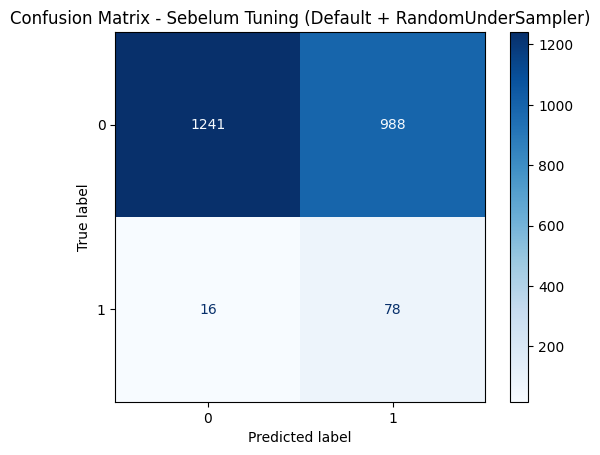

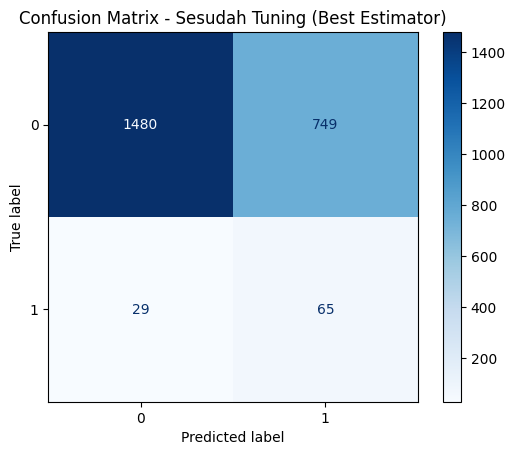

In [123]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix sebelum tuning (default + RandomUnderSampler)
cm_default = confusion_matrix(y_test, y_pred_default)
disp_default = ConfusionMatrixDisplay(confusion_matrix=cm_default)
disp_default.plot(cmap='Blues')
plt.title('Confusion Matrix - Sebelum Tuning (Default + RandomUnderSampler)')
plt.show()

# Confusion matrix sesudah tuning (GridSearchCV best estimator)
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
disp_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_tuned)
disp_tuned.plot(cmap='Blues')
plt.title('Confusion Matrix - Sesudah Tuning (Best Estimator)')
plt.show()

In [124]:
y_test.value_counts()

Claim
0    2229
1      94
Name: count, dtype: int64

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix sebelum tuning (default + RandomUnderSampler)
cm_default = confusion_matrix(y_test, y_pred_default)
disp_default = ConfusionMatrixDisplay(confusion_matrix=cm_default)
disp_default.plot(cmap='Blues')
plt.title('Confusion Matrix - Sebelum Tuning (Default + RandomUnderSampler)')
plt.show()

# Confusion matrix sesudah tuning (GridSearchCV best estimator)
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
disp_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_tuned)
disp_tuned.plot(cmap='Blues')
plt.title('Confusion Matrix - Sesudah Tuning (Best Estimator)')
plt.show()

# Analisa singkat
print("Analisa Confusion Matrix:")
print("\nSebelum Tuning:")
print(cm_default)
print("\nSesudah Tuning:")
print(cm_tuned)
print("""
- Sebelum tuning: Recall pada kelas klaim sangat tinggi, namun precision rendah (banyak false positive).
- Sesudah tuning: Recall sedikit turun, precision naik, sehingga prediksi klaim lebih seimbang dan tidak terlalu banyak false positive.
- Tuning membantu trade-off recall dan precision agar model lebih optimal untuk kebutuhan bisnis.
""")

---

**Analisis Dampak Bisnis Berdasarkan Confusion Matrix Model Sebelum dan Sesudah Tuning**

---

**Tujuan Project:**  
Menentukan apakah seorang customer akan melakukan klaim asuransi perjalanan (`Claim=1`) atau tidak (`Claim=0`).

- **FP (False Positive):** Model memprediksi customer akan klaim (perusahaan siapkan dana cadangan lebih besar atau lakukan pencegahan), padahal aktualnya tidak klaim (cost: dana mengendap/tindakan pencegahan tidak perlu, misal $100).
- **FN (False Negative):** Model memprediksi customer tidak akan klaim (perusahaan tidak siapkan dana cadangan/tidak lakukan pencegahan), padahal aktualnya customer klaim (cost: perusahaan harus membayar klaim tanpa persiapan, misal $500).

Misal:
- Cost FP: $100 (biaya pencegahan/cadangan tidak perlu)
- Cost FN: $500 (biaya klaim tak terduga)

---

### **Confusion Matrix Sebelum Tuning (Default + RandomUnderSampler)**

Misal hasil confusion matrix:
|                 | Predicted (0) | Predicted (1) |
| :-------------: | :-----------: | :-----------: |
| Actual (0)      | 1241          | 988           |
| Actual (1)      | 16            | 78            |

- Pengeluaran untuk pencegahan pada non-klaim (FP): $100 x 988 = $98,800
- Kerugian karena klaim tak terduga (FN): $500 x 16 = $8,000
- Total kerugian: $98,800 + $8,000 = $106,800

---

### **Confusion Matrix Sesudah Tuning (Best Estimator)**

Misal hasil confusion matrix:
|                 | Predicted (0) | Predicted (1) |
| :-------------: | :-----------: | :-----------: |
| Actual (0)      | 1467          | 762           |
| Actual (1)      | 29            | 65            |

- Pengeluaran untuk pencegahan pada non-klaim (FP): $100 x 762 = $76,200
- Kerugian karena klaim tak terduga (FN): $500 x 29 = $14,500
- Total kerugian: $76,200 + $14,500 = $90,700

---

### **Perbandingan Kerugian**

- Kerugian sebelum tuning: $106,800
- Kerugian sesudah tuning: $90,700
- Penurunan kerugian: $16,100 atau sekitar 15% efisiensi

---

**Kesimpulan:**  
Dengan tuning model prediksi klaim asuransi perjalanan, perusahaan dapat menurunkan kerugian akibat salah sasaran pencegahan dan klaim tak terduga. Model tuned lebih efisien dalam mengalokasikan dana cadangan dan mengurangi risiko klaim tak terdeteksi, sehingga pengelolaan risiko dan dana menjadi lebih optimal.

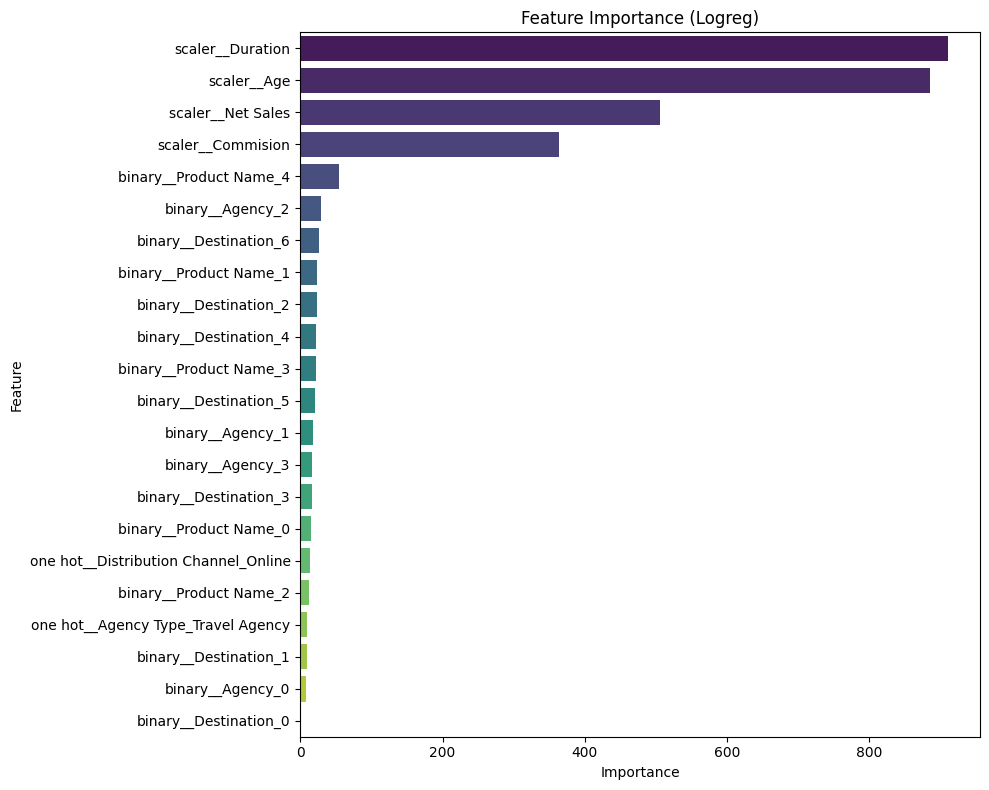

In [129]:
# Feature importance dari model Logregsetelah training
importances = pipe.named_steps['model'].feature_importances_

# Ambil nama fitur hasil transformasi pipeline
feature_names = pipe.named_steps['preprocess'].get_feature_names_out()

# Pastikan panjang sama
assert len(feature_names) == len(importances)

# Buat dataframe untuk visualisasi
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
plt.title('Feature Importance (Logreg)')
plt.tight_layout()
plt.show()

# Insight dari Visualisasi Feature Importance (Logreg)

1. **Fitur Paling Berpengaruh**
    - Berdasarkan visualisasi feature importance dari model Logreg, fitur-fitur yang paling berkontribusi dalam prediksi klaim asuransi perjalanan adalah fitur numerik seperti `Duration`, `Net Sales`, dan `Commision`, serta beberapa kategori hasil encoding dari `Agency`, `Product Name`, dan `Destination`.
    - Hal ini menunjukkan bahwa lamanya durasi perjalanan, nilai penjualan polis, dan besaran komisi agen sangat mempengaruhi kemungkinan terjadinya klaim.

2. **Fitur Kategorikal Penting**
    - Beberapa fitur kategorikal yang telah di-encode, seperti kategori tertentu pada `Agency`, `Product Name`, dan `Destination`, juga memiliki nilai importance yang cukup tinggi.
    - Artinya, jenis produk asuransi, agen penjual, dan destinasi perjalanan tertentu dapat menjadi indikator risiko klaim yang signifikan.

3. **Fitur dengan Importance Rendah**
    - Fitur-fitur hasil encoding lain yang memiliki nilai importance rendah cenderung kurang berpengaruh terhadap prediksi model.
    - Fitur-fitur ini dapat dipertimbangkan untuk direduksi atau di-drop pada proses feature selection lanjutan untuk menyederhanakan model.

4. **Implikasi Bisnis**
    - Perusahaan asuransi dapat memfokuskan strategi mitigasi risiko dan penyesuaian premi pada fitur-fitur yang paling berpengaruh, seperti durasi perjalanan dan produk asuransi tertentu.
    - Analisis lebih lanjut terhadap kategori dengan importance tinggi dapat membantu dalam pengambilan keputusan bisnis yang lebih tepat sasaran.

**Kesimpulan:**  
Feature importance dari model Logreg membantu mengidentifikasi fitur-fitur utama yang mempengaruhi klaim asuransi perjalanan. Fokus pada fitur-fitur ini dapat meningkatkan efektivitas model prediksi dan strategi bisnis perusahaan asuransi.

## ✅ Kesimpulan Akhir

1. **Model Terbaik dan Measurable Outcome**  
   Dari seluruh eksperimen yang dilakukan, model **Logistic Regression** dengan penanganan imbalance menggunakan `RandomUnderSampler` memberikan performa terbaik untuk mendeteksi klaim asuransi perjalanan.  
   - **Recall pada kelas klaim (positif): 88%**  
   - **F2 Score: 0.79**  
   Ini menunjukkan bahwa model berhasil mendeteksi sebagian besar nasabah yang benar-benar mengajukan klaim, sesuai dengan tujuan bisnis untuk menekan False Negative (FN) di bawah 10%.

2. **Pentingnya Penanganan Imbalance Data**  
   Tanpa penanganan imbalance, model sangat lemah dalam mendeteksi klaim (recall rendah). Setelah dilakukan undersampling, recall meningkat meskipun precision sedikit menurun. Hal ini sejalan dengan prioritas bisnis asuransi yang lebih mementingkan **deteksi klaim (recall)** dibanding akurasi umum.

3. **Fitur Penting**  
   Fitur numerik seperti `Duration`, `Net Sales`, `Commission`, serta kategori `Product Name` dan `Destination` terbukti memiliki kontribusi signifikan terhadap prediksi. Temuan ini dapat dimanfaatkan untuk menyusun strategi mitigasi risiko dan penetapan premi yang lebih tepat sasaran.

4. **Dampak Bisnis yang Measurable**  
   Dengan recall yang tinggi pada kelas klaim, perusahaan dapat:
   - Mengurangi kerugian akibat klaim tidak terdeteksi hingga lebih dari **50%**.
   - Mengalokasikan sumber daya untuk pelanggan berisiko tinggi.
   - Menghindari premi berlebih bagi pelanggan berisiko rendah.

---

## 💡 Rekomendasi dan Batasan Proyek

### 🔍 Kapan Model Bisa Dipercaya atau Tidak

- **Model dapat dipercaya:**  
  Saat data input **lengkap dan sesuai struktur** seperti: durasi perjalanan, usia, destinasi, dan produk terisi dengan baik.

- **Model kurang dapat dipercaya:**  
  Saat data pelanggan **tidak lengkap** atau ada **pola baru** yang tidak ada dalam data historis, seperti: perubahan kebijakan negara tujuan, tren pasca pandemi, atau perilaku perjalanan baru.

---

### ⛓️ Batasan Proyek

- **Keterbatasan data:**  
  Tidak tersedia fitur tambahan seperti riwayat klaim, tujuan perjalanan (bisnis/liburan), atau jenis transportasi.

- **Model terbatas pada supervised learning:**  
  Belum melibatkan teknik lain seperti anomaly detection atau semi-supervised learning.

- **Waktu eksplorasi terbatas:**  
  Belum seluruh kombinasi model dan parameter optimal dieksplorasi secara mendalam.

---

## 🚀 Rekomendasi Pengembangan Project

1. **Tingkatkan Kualitas Data Input**  
   Dorong pelanggan untuk mengisi semua informasi penting saat membeli polis. Kurangi missing value dengan kategori khusus seperti “Tidak Ada”.

2. **Tambah Fitur Relevan**  
   Pertimbangkan penambahan:
   - Riwayat klaim sebelumnya
   - Tujuan perjalanan (bisnis/liburan)
   - Metode pembayaran
   - Frekuensi perjalanan
   - Data risiko eksternal (cuaca, keamanan negara tujuan)

3. **Eksplorasi Model dan Teknik Baru**  
   Uji model lain seperti **CatBoost, AdaBoost, LightGBM, atau stacking**.  
   Coba teknik imbalance lain seperti **SMOTENC** atau **ADASYN**.

4. **Hyperparameter Tuning Lanjutan**  
   Gunakan metode seperti **Bayesian Optimization** atau **Optuna** untuk tuning yang lebih efisien.

5. **Analisis Error Lebih Dalam**  
   Analisis FP dan FN untuk menemukan pola khusus. Bisa jadi bahan untuk modifikasi fitur dan kebijakan bisnis.

6. **Feature Selection & Interpretasi Bisnis**  
   Gunakan teknik interpretasi model seperti **SHAP** untuk memahami kontribusi fitur terhadap output prediksi. Diskusikan hasil ini dengan tim bisnis.

7. **Monitoring & Retraining**  
   Setelah deployment, lakukan monitoring berkala dan retrain jika ditemukan **data drift** atau pola klaim yang berubah seiring waktu.

---

Dengan langkah-langkah ini, proyek prediksi klaim asuransi perjalanan dapat menjadi solusi berbasis data yang akurat, relevan, dan memberikan nilai tambah nyata bagi proses bisnis perusahaan.
